In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: C:\Users\jean-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# rajouter les imports ci dessous

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from itertools import cycle

In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: C:\Users\jean-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: C:\Users\jean-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import pandas as pd
import sklearn as skl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV, MultiTaskElasticNetCV, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from tqdm import tqdm 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [6]:
from sklearn.ensemble import RandomForestClassifier


In [7]:
from statsmodels.tsa.stattools import acf

In [8]:

from xgboost import XGBClassifier

In [85]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix
from itertools import cycle

# I- Training linear models on daily data 

We will try to train models on both daily and weekly data. We may see some different dynamics between daily and weekly data: it could be easier to train a model on weekly data because there is less autocorrelation between datapoints. However in the meanwhile, the dataset on daily datapoints may be bigger so it could also be easier to train models on daily data. 

In [ ]:
datapath = os.path.join('data', 'US', 'us_data.csv')
dus = pd.read_csv(datapath, index_col=0)

In [ ]:
cols_inf = dus.columns[np.isinf(dus.to_numpy()).any(axis=0)]
print(cols_inf)

In [ ]:
dus.hist(figsize=(23, 23), bins=100)
plt.tight_layout()

### A) Creating new features.

Now we need to add the lagged values of yields as features. We have to choose lags and yields to add as features. 

In [ ]:

for USyield in ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3','DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']:
    series = dus[USyield]
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    plot_acf(series, lags=90,title = f'ACF {USyield}', ax = axes[0])
    plot_pacf(series, lags=90,title = f'PACF {USyield}',ax = axes[1])

    for ax in axes:
        ax.set_xlim(0.5, 90)  # décale le début après 0
        ax.set_ylim(-0.2, 0.2) 

        if USyield in ['DGS5','DGS7','DGS10', 'DGS20', 'DGS30']:
            
            ax.axvline(x=25, color='red', linestyle='--', linewidth=1)
            ax.axvline(x=50, color='red', linestyle='--', linewidth=1)

    
    plt.show()


- We can see that on short term yields, there is much more autocorrelation in the data, up to more than 30 days. Returns in the past few days are highly correlated to returns in the next days. 
- However, on long term yields, there is much less autocorrelation and returns in the past 2 days are only slightly correlated to next day return. Surprisingly we see some persistent autocorrelation between returns at day t and t-25 and t-50. 

For maturities less than 1y, we'll add the following lags:
- t-1,t-2,t-5,t-10,t-15,t-20,t-25,t-30,t-40,t-50

For maturities more than 1y, we will add:
- t-1,t-2,t-10,t-25,t-50

We will probably need to do some PCA to combine features as they will be very correlated.

In [ ]:
for lag in [1,2,5,10,15,20,25,30,40,50]:
    dus[f'DGS1MO_t-{lag}'] = dus['DGS1MO'].shift(lag-1)
    dus[f'DGS3MO_t-{lag}'] = dus['DGS3MO'].shift(lag-1)
    dus[f'DGS6MO_t-{lag}'] = dus['DGS6MO'].shift(lag-1)
    dus[f'DGS1_t-{lag}'] = dus['DGS1'].shift(lag-1)
  

for lag in [1,2,10,15,25,50]:
    dus[f'DGS1_t-{lag}'] = dus['DGS1'].shift(lag-1)
    dus[f'DGS2_t-{lag}'] = dus['DGS2'].shift(lag-1)
    dus[f'DGS3_t-{lag}'] = dus['DGS3'].shift(lag-1)
    dus[f'DGS5_t-{lag}'] = dus['DGS5'].shift(lag-1)
    dus[f'DGS7_t-{lag}'] = dus['DGS7'].shift(lag-1)
    dus[f'DGS10_t-{lag}'] = dus['DGS10'].shift(lag-1)
    dus[f'DGS20_t-{lag}'] = dus['DGS20'].shift(lag-1)
    dus[f'DGS30_t-{lag}'] = dus['DGS30'].shift(lag-1)

In [ ]:
#creating variables to forecast 

dus['Y_1MO'] = dus['DGS1MO'].shift(-1)
dus['Y_3MO'] = dus['DGS3MO'].shift(-1)
dus['Y_6MO'] = dus['DGS6MO'].shift(-1)
dus['Y_1year'] = dus['DGS1'].shift(-1)
dus['Y_2year'] = dus['DGS2'].shift(-1)
dus['Y_3year'] = dus['DGS3'].shift(-1)
dus['Y_5year'] = dus['DGS5'].shift(-1)
dus['Y_7year'] = dus['DGS7'].shift(-1)
dus['Y_10year'] = dus['DGS10'].shift(-1)
dus['Y_20year'] = dus['DGS20'].shift(-1)
dus['Y_30year'] = dus['DGS30'].shift(-1)

In [ ]:
#we can now remove the original yield columns
dus = dus.drop(columns=['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3','DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'])

We can now look at the heatmap:

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(dus.corr(), cmap='seismic', center=0)

Overall the features have a very low correlation with the target, so we'll remove the least correlated ones: 

- the lagged features that have a correlation coefficient < 0.05 in absolute value with all target variables. 
- the other features that have a correlation coefficient < 0.03 in absolute value with all target variables. We do a distinction between lagged features and other features because filtering all features with the 0.05 threshold removes somes features that should have a predictive impact: sp500, gold, VIX for instance. 

Moreover, given the very high correlation between lagged features, we'll apply a PCA in the pipeline on those to limit the number of colinear features.

In [ ]:
Y = dus[['Y_1MO', 'Y_3MO', 'Y_6MO', 'Y_1year', 'Y_2year', 'Y_3year', 'Y_5year', 'Y_7year', 'Y_10year', 'Y_20year', 'Y_30year']]
dus_lagged_features = dus[[col for col in dus.columns if '_t-' in col]]
dus_other =dus.drop(columns=[col for col in dus.columns if '_t-' in col])

corrs = pd.DataFrame({
    target: dus_lagged_features.corrwith(Y[target]) for target in Y.columns
}).abs()  

# repérer les colonnes où la corrélation absolue < 0.05 pour toutes les targets
mask = (corrs < 0.05).all(axis=1)
low_corr_features = corrs.index[mask]

# supprimer ces colonnes
dus_filtered = dus.drop(columns=low_corr_features)



corrs = pd.DataFrame({
    target: dus_other.corrwith(Y[target]) for target in Y.columns
}).abs()  

# repérer les colonnes où la corrélation absolue < 0.05 pour toutes les targets
mask = (corrs < 0.03).all(axis=1)
low_corr_features_2 = corrs.index[mask]

# supprimer ces colonnes
dus_filtered = dus_filtered.drop(columns=low_corr_features_2)

print(f"{len(low_corr_features) + len(low_corr_features_2)} features were deleted")

In [ ]:
print(low_corr_features)
print(low_corr_features_2)

In [ ]:
plt.figure(figsize = (20,20))
sns.heatmap(dus_filtered.corr(), cmap='seismic', center=0)

### B) PCA 

In [ ]:
dus_filtered = dus_filtered.dropna()
X = dus_filtered[['USGOOD', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'USWTRADE',
       'USFIRE', 'PERMIT', 'UMCSENT', 'M2SL', 'M2REAL', 'TOTRESNS', 'CPIAUCSL',
       'CPIAPPSL', 'CPITRNSL', 'CUSR0000SAC', 'CPIULFSL', 'CUUR0000SA0L2',
       'PCEPI', 'DNDGRG3M086SBEA', 'MTSDS133FMS', 'GFDEGDQ188S',
       'IRLTLT01DEM156N', 'IRLTLT01JPM156N', 'IRLTLT01GBM156N',
       'IRLTLT01CAM156N', 'IRLTLT01AUM156N', 'IRLTLT01FRM156N', 'NASDAQCOM',
       'AAA', 'BAA', 'DEXCAUS', 'DEXUSAL', 'NFCI', 'FEDFUNDS', 'BOGMBASE',
       'WSHOSHO', 'T5YIE', 'T10YIE', 'log return gold', 'log return sp500',
       'DGS1MO_t-1', 'DGS3MO_t-1', 'DGS6MO_t-1', 'DGS1_t-1', 'DGS1MO_t-2',
       'DGS3MO_t-2', 'DGS6MO_t-2', 'DGS1MO_t-5', 'DGS3MO_t-5', 'DGS6MO_t-5',
       'DGS3MO_t-10', 'DGS6MO_t-10', 'DGS1_t-10', 'DGS1MO_t-15', 'DGS3MO_t-15',
       'DGS6MO_t-15', 'DGS1MO_t-20', 'DGS3MO_t-20', 'DGS6MO_t-20', 'DGS1_t-20',
       'DGS3MO_t-30', 'DGS6MO_t-40', 'DGS1MO_t-50', 'DGS2_t-1', 'DGS3_t-1',
       'DGS10_t-1', 'DGS20_t-1', 'DGS30_t-1', 'DGS7_t-50', 'DGS10_t-50',
       'DGS20_t-50', 'DGS30_t-50']]

Y = dus_filtered[['Y_1MO', 'Y_3MO', 'Y_6MO', 'Y_1year', 'Y_2year', 'Y_3year', 'Y_5year', 'Y_7year', 'Y_10year', 'Y_20year', 'Y_30year']]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Number of components kept:", pca.n_components_)
print("cumulative explained variance :", pca.explained_variance_ratio_.cumsum())
print("Composantes principales (coefficients sur les features originales) :")
print(pca.components_)

print("Exemple des nouvelles features transformées :")
print(X_pca[:5])

In [ ]:
# calculer la contribution absolue sur PC1 et PC2
pc1, pc2 = np.abs(pca.components_[:2])
importance = pc1 + pc2

# garder les n features les plus importantes
n = 30
top_idx = np.argsort(importance)[-n:]
top_labels = X.columns[top_idx]
top_components = pca.components_[:2, top_idx]

plt.figure(figsize=(12,12))
circle = plt.Circle((0,0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)

for i, (x, y) in enumerate(zip(top_components[0,:], top_components[1,:])):
    plt.arrow(0, 0, x, y, color='r', alpha=0.6, head_width=0.02)
    plt.text(x*1.15, y*1.15, top_labels[i], color='b', ha='center', va='center', fontsize=9)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Correlation circle (top features)")
plt.grid()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()


We can see that features are overall very correlated, so we'll train some models with PCA and some without.

### C) Training a ridge model

We do a walk forward cross validation:
- we train our model on 4 years of data (= approximately 1000 data points)
- we do prediction for the next month (21 days)
- wa add a PCA to the pipeline to deal with correlated features. We'll also train a model without PCA to see how it changes the performance.

In [ ]:


window_train = 252 *4
window_pred = 21          
alphas = np.logspace(-3, 3, 20)


tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95)),   
    ('ridge', MultiOutputRegressor(RidgeCV(fit_intercept=False,alphas=alphas, cv=tscv)))
])

pipe_nopca = Pipeline([
    ('scaler',StandardScaler()),   
    ('ridge', MultiOutputRegressor(RidgeCV(fit_intercept=False,alphas=alphas, cv=tscv)))
])

preds = []
dates_pred = []
r2_is_list = []
r2_os_list=[]
hit_rate_list = []

preds_nopca = []
dates_pred_nopca = []
r2_is_list_nopca = []
r2_os_list_nopca=[]
hit_rate_list_nopca = []

for start in tqdm(range(0, len(X) - window_train - window_pred + 1, window_pred)):
  
    end_train = start + window_train
    end_pred = end_train + window_pred

    X_train = X.iloc[start:end_train]
    Y_train = Y.iloc[start:end_train]

    X_test = X.iloc[end_train:end_pred]
    Y_test = Y.iloc[end_train:end_pred]


    # model with PCA 
    pipe.fit(X_train, Y_train)

    Y_pred = pipe.predict(X_test)

    preds.append(Y_pred)
    dates_pred.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred), axis=0)
    r2_is_list.append(r2_is)
    r2_os_list.append(r2_oos)
    hit_rate_list.append(hit_rate)


    # model without PCA 
    pipe_nopca.fit(X_train, Y_train)

    Y_pred_nopca = pipe_nopca.predict(X_test)

    preds_nopca.append(Y_pred)
    dates_pred_nopca.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred_nopca, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe_nopca.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred_nopca, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred_nopca), axis=0)
    r2_is_list_nopca.append(r2_is)
    r2_os_list_nopca.append(r2_oos)
    hit_rate_list_nopca.append(hit_rate)





In [ ]:
r2_is_df = pd.DataFrame(r2_is_list) 
r2_is_df_nopca = pd.DataFrame(r2_is_list_nopca) 
r2_is_df.columns = Y.columns
r2_is_df_nopca.columns = Y.columns
r2_is_df.index = [date[0] for date in dates_pred]
r2_is_df_nopca.index = [date[0] for date in dates_pred]


r2_os_df = pd.DataFrame(r2_os_list)  
r2_os_df.columns = Y.columns
r2_os_df.index = [date[0] for date in dates_pred]
r2_os_df_nopca = pd.DataFrame(r2_os_list_nopca) 
r2_os_df_nopca.columns = Y.columns
r2_os_df_nopca.index = [date[0] for date in dates_pred]


hr = pd.DataFrame(hit_rate_list) 
hr.columns = Y.columns
hr.index = [date[0] for date in dates_pred]
hr_nopca = pd.DataFrame(hit_rate_list_nopca) 
hr_nopca.columns = Y.columns
hr_nopca.index = [date[0] for date in dates_pred]


plt.close('all')  # ferme toutes les figures existantes


fig, ax = plt.subplots(3,2,figsize=(28,28))

r2_is_df.plot(ax = ax[0,0],title = 'Evolution of in sample R2 per model with PCA, per sample')
ax[0,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_is_df_nopca.plot(ax = ax[0,1],title = 'Evolution of in sample R2 per model without PCA, per sample')
ax[0,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


r2_os_df.plot(ax = ax[1,0], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per model with PCA, per sample')
ax[1,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_os_df_nopca.plot(ax = ax[1,1], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per model without PCA, per sample')
ax[1,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

hr.plot(ax = ax[2,0], title = 'Evolution of out-sample hit rate per model with PCA, per sample')
ax[2,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
hr_nopca.plot(ax = ax[2,1], title = 'Evolution of out-sample hit rate per model without PCA, per sample')
ax[2,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

- When looking at the in sample R2 of our models, we see that the R2 is overall low, but that it is better on short term yields, ie from 1 month to 1 year, and significantly lower for long-term yields. 
- we see significant variations in R2 in 2011 and 2020, probably because of outliers. 

- The out of sample R2 is close to zero or even negative so there is no predictive power in our model.

- adding a PCA in the pipeline do not change anything to the in sample R2. However, the hit rate is slightly less variable when adding the PCA, suggesting a bit less overfitting (although the out of sample results are as bad).
- The hit rate seems to be close to 0.5 on average for all models and all samples. So it appears the model does not do anything better than predicting at random - it completely overfits the data.



## Training Lasso

In [ ]:
np.logspace(-5, 2, 20)

In [ ]:
window_train = 252 *4
window_pred = 21          
alphas = np.logspace(-5, 2, 20)


tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95)),   
    ('lasso', MultiTaskLassoCV(fit_intercept=False,alphas=alphas, cv=tscv))
])

pipe_nopca = Pipeline([
    ('scaler',StandardScaler()),   
    ('lasso', MultiTaskLassoCV(fit_intercept=False,alphas=alphas, cv=tscv))
])

preds = []
dates_pred = []
r2_is_list = []
r2_os_list=[]
hit_rate_list = []
alpha,selected_features = [],[]

preds_nopca = []
dates_pred_nopca = []
r2_is_list_nopca = []
r2_os_list_nopca=[]
hit_rate_list_nopca = []
alpha_nopca,selected_features_nopca = [],[]

for start in tqdm(range(0, len(X) - window_train - window_pred + 1, window_pred)):
  
    end_train = start + window_train
    end_pred = end_train + window_pred

    X_train = X.iloc[start:end_train]
    Y_train = Y.iloc[start:end_train]

    X_test = X.iloc[end_train:end_pred]
    Y_test = Y.iloc[end_train:end_pred]


    # model with PCA 
    pipe.fit(X_train, Y_train)

    Y_pred = pipe.predict(X_test)

    preds.append(Y_pred)
    dates_pred.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred), axis=0)
    r2_is_list.append(r2_is)
    r2_os_list.append(r2_oos)
    hit_rate_list.append(hit_rate)
    alpha.append(pipe.named_steps['lasso'].alpha_)
    selected_features.append(np.sum(np.any(pipe.named_steps['lasso'].coef_!=0,axis=0)))


    # model without PCA 
    pipe_nopca.fit(X_train, Y_train)

    Y_pred_nopca = pipe_nopca.predict(X_test)

    preds_nopca.append(Y_pred)
    dates_pred_nopca.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred_nopca, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe_nopca.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred_nopca, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred_nopca), axis=0)
    r2_is_list_nopca.append(r2_is)
    r2_os_list_nopca.append(r2_oos)
    hit_rate_list_nopca.append(hit_rate)
    alpha_nopca.append(pipe_nopca.named_steps['lasso'].alpha_)
    selected_features_nopca.append(np.sum(np.any(pipe_nopca.named_steps['lasso'].coef_!=0,axis=0)))






In [ ]:
r2_is_df = pd.DataFrame(r2_is_list) 
r2_is_df_nopca = pd.DataFrame(r2_is_list_nopca) 
r2_is_df.columns = Y.columns
r2_is_df_nopca.columns = Y.columns
r2_is_df.index = [date[0] for date in dates_pred]
r2_is_df_nopca.index = [date[0] for date in dates_pred]


r2_os_df = pd.DataFrame(r2_os_list)  
r2_os_df.columns = Y.columns
r2_os_df.index = [date[0] for date in dates_pred]
r2_os_df_nopca = pd.DataFrame(r2_os_list_nopca) 
r2_os_df_nopca.columns = Y.columns
r2_os_df_nopca.index = [date[0] for date in dates_pred]


hr = pd.DataFrame(hit_rate_list) 
hr.columns = Y.columns
hr.index = [date[0] for date in dates_pred]
hr_nopca = pd.DataFrame(hit_rate_list_nopca) 
hr_nopca.columns = Y.columns
hr_nopca.index = [date[0] for date in dates_pred]

fs = pd.DataFrame(selected_features)
fs.index = [date[0] for date in dates_pred]

fs_nopca = pd.DataFrame(selected_features_nopca)
fs_nopca.index = [date[0] for date in dates_pred]


alphadf = pd.DataFrame(alpha)
alphadf.index = [date[0] for date in dates_pred]

alphadf_nopca = pd.DataFrame(alpha_nopca)
alphadf_nopca.index = [date[0] for date in dates_pred]




fig, ax = plt.subplots(5,2,figsize=(28,28))

r2_is_df.plot(ax = ax[0,0],title = 'Evolution of in sample R2 per maturity with PCA, per sample')
ax[0,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_is_df_nopca.plot(ax = ax[0,1],title = 'Evolution of in sample R2 per maturity without PCA, per sample')
ax[0,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


r2_os_df.plot(ax = ax[1,0], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity with PCA, per sample')
ax[1,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_os_df_nopca.plot(ax = ax[1,1], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity without PCA, per sample')
ax[1,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

hr.plot(ax = ax[2,0], title = 'Evolution of out-sample hit rate per maturity with PCA, per sample')
ax[2,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
hr_nopca.plot(ax = ax[2,1], title = 'Evolution of out-sample hit rate per maturity without PCA, per sample')
ax[2,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


fs.plot(ax = ax[3,0], title = 'Evolution of number of selected features with PCA, per sample')
ax[3,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
fs_nopca.plot(ax = ax[3,1], title = 'Evolution of number of selected features without PCA, per sample')
ax[3,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

alphadf.plot(ax = ax[4,0], title = 'Evolution of alpha selected by cross validation - model with PCA, per sample')
ax[4,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
alphadf_nopca.plot(ax = ax[4,1], title = 'Evolution of alpha selected by cross validation - model without PCA, per sample')
ax[4,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

Lasso performance is even worse than that of ridge because there are some periods for which the model selects no features. 

## Training Elastic net 

In [ ]:
window_train = 252 *10
window_pred = 21          
alphas = np.logspace(-3, 2, 20)
l1_ratios = [0.25,0.5,0.75]


tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95)),   
    ('elasticnet', MultiTaskElasticNetCV(alphas=alphas, cv=tscv, l1_ratio=0.5, fit_intercept=False,max_iter=5000))
])

pipe_nopca = Pipeline([
    ('scaler',StandardScaler()),   
    ('elasticnet', MultiTaskElasticNetCV(alphas=alphas, cv=tscv, l1_ratio=l1_ratios, fit_intercept=False,max_iter=5000))
])

preds = []
dates_pred = []
r2_is_list = []
r2_os_list=[]
hit_rate_list = []
alpha,selected_features,l1 = [],[],[]

preds_nopca = []
dates_pred_nopca = []
r2_is_list_nopca = []
r2_os_list_nopca=[]
hit_rate_list_nopca = []
alpha_nopca,selected_features_nopca,l1_nopca = [],[],[]

for start in tqdm(range(0, len(X) - window_train - window_pred + 1, window_pred)):
  
    end_train = start + window_train
    end_pred = end_train + window_pred

    X_train = X.iloc[start:end_train]
    Y_train = Y.iloc[start:end_train]

    X_test = X.iloc[end_train:end_pred]
    Y_test = Y.iloc[end_train:end_pred]


    # model with PCA 
    pipe.fit(X_train, Y_train)

    Y_pred = pipe.predict(X_test)

    preds.append(Y_pred)
    dates_pred.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred), axis=0)
    r2_is_list.append(r2_is)
    r2_os_list.append(r2_oos)
    hit_rate_list.append(hit_rate)
    alpha.append(pipe.named_steps['elasticnet'].alpha_)
    selected_features.append(np.sum(np.any(pipe.named_steps['elasticnet'].coef_!=0,axis=0)))
    l1.append(pipe.named_steps['elasticnet'].l1_ratio_)


    # model without PCA 
    pipe_nopca.fit(X_train, Y_train)

    Y_pred_nopca = pipe_nopca.predict(X_test)

    preds_nopca.append(Y_pred)
    dates_pred_nopca.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred_nopca, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe_nopca.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred_nopca, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred_nopca), axis=0)
    r2_is_list_nopca.append(r2_is)
    r2_os_list_nopca.append(r2_oos)
    hit_rate_list_nopca.append(hit_rate)
    alpha_nopca.append(pipe_nopca.named_steps['elasticnet'].alpha_)
    selected_features_nopca.append(np.sum(np.any(pipe_nopca.named_steps['elasticnet'].coef_!=0,axis=0)))
    l1_nopca.append(pipe_nopca.named_steps['elasticnet'].l1_ratio_)






In [ ]:
r2_is_df = pd.DataFrame(r2_is_list) 
r2_is_df_nopca = pd.DataFrame(r2_is_list_nopca) 
r2_is_df.columns = Y.columns
r2_is_df_nopca.columns = Y.columns
r2_is_df.index = [date[0] for date in dates_pred]
r2_is_df_nopca.index = [date[0] for date in dates_pred]


r2_os_df = pd.DataFrame(r2_os_list)  
r2_os_df.columns = Y.columns
r2_os_df.index = [date[0] for date in dates_pred]
r2_os_df_nopca = pd.DataFrame(r2_os_list_nopca) 
r2_os_df_nopca.columns = Y.columns
r2_os_df_nopca.index = [date[0] for date in dates_pred]


hr = pd.DataFrame(hit_rate_list) 
hr.columns = Y.columns
hr.index = [date[0] for date in dates_pred]
hr_nopca = pd.DataFrame(hit_rate_list_nopca) 
hr_nopca.columns = Y.columns
hr_nopca.index = [date[0] for date in dates_pred]

fs = pd.DataFrame(selected_features)
fs.index = [date[0] for date in dates_pred]

fs_nopca = pd.DataFrame(selected_features_nopca)
fs_nopca.index = [date[0] for date in dates_pred]


alphadf = pd.DataFrame(alpha)
alphadf.index = [date[0] for date in dates_pred]

alphadf_nopca = pd.DataFrame(alpha_nopca)
alphadf_nopca.index = [date[0] for date in dates_pred]


l1df = pd.DataFrame(l1)
l1df.index = [date[0] for date in dates_pred]

l1df_nopca = pd.DataFrame(l1_nopca)
l1df_nopca.index = [date[0] for date in dates_pred]







fig, ax = plt.subplots(6,2,figsize=(28,28))

r2_is_df.plot(ax = ax[0,0],title = 'Evolution of in sample R2 per maturity with PCA, per sample')
ax[0,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_is_df_nopca.plot(ax = ax[0,1],title = 'Evolution of in sample R2 per maturity without PCA, per sample')
ax[0,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


r2_os_df.plot(ax = ax[1,0], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity with PCA, per sample')
ax[1,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_os_df_nopca.plot(ax = ax[1,1], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity without PCA, per sample')
ax[1,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

hr.plot(ax = ax[2,0], title = 'Evolution of out-sample hit rate per maturity with PCA, per sample')
ax[2,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
hr_nopca.plot(ax = ax[2,1], title = 'Evolution of out-sample hit rate per maturity without PCA, per sample')
ax[2,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


fs.plot(ax = ax[3,0], title = 'Evolution of number of selected features with PCA, per sample')
ax[3,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
fs_nopca.plot(ax = ax[3,1], title = 'Evolution of number of selected features without PCA, per sample')
ax[3,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

alphadf.plot(ax = ax[4,0], title = 'Evolution of alpha selected by cross validation - model with PCA, per sample')
ax[4,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
alphadf_nopca.plot(ax = ax[4,1], title = 'Evolution of alpha selected by cross validation - model without PCA, per sample')
ax[4,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

l1df.plot(ax = ax[5,0], title = 'Evolution of L1 ratio selected by cross validation - model with PCA, per sample')
ax[5,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
l1df_nopca.plot(ax = ax[5,1], title = 'Evolution of L1 ratio selected by cross validation - model without PCA, per sample')
ax[5,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

Overall all these linear models work very poorly, which is not surprising given the low correlation between features and past yields. We can now try to work on weekly data, which may be a bit less noisy: hopefully our model will be able to better identify some trends and patterns. 

# II) Training linear models on weekly data 

In [ ]:
datapath = os.path.join('data', 'US', 'us_data_weekly.csv')
dus = pd.read_csv(datapath, index_col=0)

In [ ]:
dus = dus[dus.index>'2003-01-03']

### A) Creating new features

In [ ]:

for USyield in ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3','DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']:
    series = dus[USyield]
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    plot_acf(series, lags=50,title = f'ACF {USyield}', ax = axes[0])
    plot_pacf(series, lags=50,title = f'PACF {USyield}',ax = axes[1])
    

    for ax in axes:
        ax.set_xlim(0.5, 50)  # décale le début après 0
        ax.set_ylim(-0.2, 0.2) 

    
    plt.show()


- We can see that on short term yields, there is much more autocorrelation in the data, up to 40 lags. Returns in the past few weeks (and so on the past year) are highly correlated to returns in the next week. 
- However, on long term yields, there is much less autocorrelation and returns in the past 2 weeks are only very slightly correlated to next day return. Surprisingly we see some persistent autocorrelation between returns at day t and t-25 and t-50. 

For maturities less than 1y, we'll add the following lags:
- t-1,t-2,t-5,t-10,t-15,t-20,t-25,t-30,t-40

For maturities more than 1y, we will add:
- t-1,t-2,t-10

We will probably need to do some PCA to combine features as they will be very correlated.

In [ ]:
for lag in [1,2,5,10,15,20,25,30,40,50]:
    dus[f'DGS1MO_t-{lag}'] = dus['DGS1MO'].shift(lag-1)
    dus[f'DGS3MO_t-{lag}'] = dus['DGS3MO'].shift(lag-1)
    dus[f'DGS6MO_t-{lag}'] = dus['DGS6MO'].shift(lag-1)
    dus[f'DGS1_t-{lag}'] = dus['DGS1'].shift(lag-1)
  

for lag in [1,2,10]:
    dus[f'DGS1_t-{lag}'] = dus['DGS1'].shift(lag-1)
    dus[f'DGS2_t-{lag}'] = dus['DGS2'].shift(lag-1)
    dus[f'DGS3_t-{lag}'] = dus['DGS3'].shift(lag-1)
    dus[f'DGS5_t-{lag}'] = dus['DGS5'].shift(lag-1)
    dus[f'DGS7_t-{lag}'] = dus['DGS7'].shift(lag-1)
    dus[f'DGS10_t-{lag}'] = dus['DGS10'].shift(lag-1)
    dus[f'DGS20_t-{lag}'] = dus['DGS20'].shift(lag-1)
    dus[f'DGS30_t-{lag}'] = dus['DGS30'].shift(lag-1)

In [ ]:
#creating variables to forecast 

dus['Y_1MO'] = dus['DGS1MO'].shift(-1)
dus['Y_3MO'] = dus['DGS3MO'].shift(-1)
dus['Y_6MO'] = dus['DGS6MO'].shift(-1)
dus['Y_1year'] = dus['DGS1'].shift(-1)
dus['Y_2year'] = dus['DGS2'].shift(-1)
dus['Y_3year'] = dus['DGS3'].shift(-1)
dus['Y_5year'] = dus['DGS5'].shift(-1)
dus['Y_7year'] = dus['DGS7'].shift(-1)
dus['Y_10year'] = dus['DGS10'].shift(-1)
dus['Y_20year'] = dus['DGS20'].shift(-1)
dus['Y_30year'] = dus['DGS30'].shift(-1)

We'll also add statistical features like the mean, variance, autocorrelation, quantiles of the time series to forecast.

In [ ]:
def add_ts_features(df, cols, max_lag=30, windows=[20, 60]):
    features = pd.DataFrame(index=df.index)
    
    for col in cols:
        y = df[col]

  
        # --- Statistiques glissantes ---
        for w in windows:
            features[f'{col}_mean_{w}'] = y.rolling(w).mean()
            features[f'{col}_std_{w}'] = y.rolling(w).std()
            features[f'{col}_q25_{w}'] = y.rolling(w).quantile(0.25)
            features[f'{col}_q75_{w}'] = y.rolling(w).quantile(0.75)
            features[f'{col}_q05_{w}'] = y.rolling(w).quantile(0.1)
            features[f'{col}_q90_{w}'] = y.rolling(w).quantile(0.9)
            features[f'{col}_range_{w}'] = y.rolling(w).max() - y.rolling(w).min() 
        
       
        # --- Autocorrélations locales ---
        for lag in range(1, max_lag + 1):
            features[f'{col}_autocorr_{lag}'] = (
                y.rolling(window=max(windows)).apply(lambda x: x.autocorr(lag=lag), raw=False)
            )
        
    return features

# Exemple d’usage :
cols = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3',
        'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

dus_features = add_ts_features(dus, cols)


In [ ]:
dus_features.dropna()

In [ ]:
dus = dus.merge(dus_features, how = 'inner', left_index=True, right_index=True)

In [ ]:
dus = dus.dropna()
dus

In [ ]:
#we can now remove the original yield columns
dus = dus.drop(columns=['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3','DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'])

Many features aren't that much correlated to the target, so we'll remove all features with correlation lower than 0.1 to the target.

In [ ]:
Y = dus[['Y_1MO', 'Y_3MO', 'Y_6MO', 'Y_1year', 'Y_2year', 'Y_3year', 'Y_5year', 'Y_7year', 'Y_10year', 'Y_20year', 'Y_30year']]

corrs = pd.DataFrame({
    target: dus.corrwith(Y[target]) for target in Y.columns
}).abs()  

# repérer les colonnes où la corrélation absolue < 0.05 pour toutes les targets
mask = (corrs < 0.1).all(axis=1)
low_corr_features = corrs.index[mask]

# supprimer ces colonnes
dus_filtered = dus.drop(columns=low_corr_features)

print(f"{len(low_corr_features)} features were deleted")

In [ ]:
print(low_corr_features)

In [ ]:
plt.figure(figsize = (25,25))
sns.heatmap(dus_filtered.corr(), cmap='seismic', center=0)

In [ ]:
print(dus_filtered.shape)

### B) Training a ridge model 

We can now try to train a ridge.

In [ ]:
Y = dus_filtered[['Y_1MO', 'Y_3MO', 'Y_6MO', 'Y_1year', 'Y_2year', 'Y_3year', 'Y_5year', 'Y_7year', 'Y_10year', 'Y_20year', 'Y_30year']]

X = dus_filtered.drop(columns = ['Y_1MO', 'Y_3MO', 'Y_6MO', 'Y_1year', 'Y_2year', 'Y_3year', 'Y_5year', 'Y_7year', 'Y_10year', 'Y_20year', 'Y_30year'])

In [ ]:
window_train = 52*5 #we train our model on 5 years of data and test it on the next month 
window_pred = 4          
alphas = np.logspace(-1, 3, 20)


tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95)),   
    ('ridge', MultiOutputRegressor(RidgeCV(fit_intercept=False,alphas=alphas, cv=tscv)))
])

pipe_nopca = Pipeline([
    ('scaler',StandardScaler()),   
    ('ridge', MultiOutputRegressor(RidgeCV(fit_intercept=False,alphas=alphas, cv=tscv)))
])

preds = []
dates_pred = []
r2_is_list = []
r2_os_list=[]
hit_rate_list = []

preds_nopca = []
dates_pred_nopca = []
r2_is_list_nopca = []
r2_os_list_nopca=[]
hit_rate_list_nopca = []

for start in tqdm(range(0, len(X) - window_train - window_pred + 1, window_pred)):
  
    end_train = start + window_train
    end_pred = end_train + window_pred

    X_train = X.iloc[start:end_train]
    Y_train = Y.iloc[start:end_train]

    X_test = X.iloc[end_train:end_pred]
    Y_test = Y.iloc[end_train:end_pred]


    # model with PCA 
    pipe.fit(X_train, Y_train)

    Y_pred = pipe.predict(X_test)

    preds.append(Y_pred)
    dates_pred.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred), axis=0)
    r2_is_list.append(r2_is)
    r2_os_list.append(r2_oos)
    hit_rate_list.append(hit_rate)


    # model without PCA 
    pipe_nopca.fit(X_train, Y_train)

    Y_pred_nopca = pipe_nopca.predict(X_test)

    preds_nopca.append(Y_pred)
    dates_pred_nopca.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred_nopca, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe_nopca.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred_nopca, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred_nopca), axis=0)
    r2_is_list_nopca.append(r2_is)
    r2_os_list_nopca.append(r2_oos)
    hit_rate_list_nopca.append(hit_rate)





In [ ]:
r2_is_df = pd.DataFrame(r2_is_list) 
r2_is_df_nopca = pd.DataFrame(r2_is_list_nopca) 
r2_is_df.columns = Y.columns
r2_is_df_nopca.columns = Y.columns
r2_is_df.index = [date[0] for date in dates_pred]
r2_is_df_nopca.index = [date[0] for date in dates_pred]


r2_os_df = pd.DataFrame(r2_os_list)  
r2_os_df.columns = Y.columns
r2_os_df.index = [date[0] for date in dates_pred]
r2_os_df_nopca = pd.DataFrame(r2_os_list_nopca) 
r2_os_df_nopca.columns = Y.columns
r2_os_df_nopca.index = [date[0] for date in dates_pred]


hr = pd.DataFrame(hit_rate_list) 
hr.columns = Y.columns
hr.index = [date[0] for date in dates_pred]
hr_nopca = pd.DataFrame(hit_rate_list_nopca) 
hr_nopca.columns = Y.columns
hr_nopca.index = [date[0] for date in dates_pred]


plt.close('all')  # ferme toutes les figures existantes


fig, ax = plt.subplots(3,2,figsize=(28,28))

r2_is_df.plot(ax = ax[0,0],title = 'Evolution of in sample R2 per model with PCA, per sample')
ax[0,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_is_df_nopca.plot(ax = ax[0,1],title = 'Evolution of in sample R2 per model without PCA, per sample')
ax[0,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


r2_os_df.plot(ax = ax[1,0], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per model with PCA, per sample')
ax[1,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_os_df_nopca.plot(ax = ax[1,1], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per model without PCA, per sample')
ax[1,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

hr.plot(ax = ax[2,0], title = 'Evolution of out-sample hit rate per model with PCA, per sample')
ax[2,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
hr_nopca.plot(ax = ax[2,1], title = 'Evolution of out-sample hit rate per model without PCA, per sample')
ax[2,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

Results are slightly better than when working on daily data, but we still only learn noise and completely overfit the data.

### B) Training an elastic net model

In [ ]:
window_train = 52*5
window_pred = 4         
alphas = np.logspace(-2, 2, 20)
l1_ratios = [0.25,0.5,0.75]


tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95)),   
    ('elasticnet', MultiTaskElasticNetCV(alphas=alphas, cv=tscv, l1_ratio=0.5, fit_intercept=False,max_iter=5000))
])

pipe_nopca = Pipeline([
    ('scaler',StandardScaler()),   
    ('elasticnet', MultiTaskElasticNetCV(alphas=alphas, cv=tscv, l1_ratio=l1_ratios, fit_intercept=False,max_iter=5000))
])

preds = []
dates_pred = []
r2_is_list = []
r2_os_list=[]
hit_rate_list = []
alpha,selected_features,l1 = [],[],[]

preds_nopca = []
dates_pred_nopca = []
r2_is_list_nopca = []
r2_os_list_nopca=[]
hit_rate_list_nopca = []
alpha_nopca,selected_features_nopca,l1_nopca = [],[],[]

for start in tqdm(range(0, len(X) - window_train - window_pred + 1, window_pred)):
  
    end_train = start + window_train
    end_pred = end_train + window_pred

    X_train = X.iloc[start:end_train]
    Y_train = Y.iloc[start:end_train]

    X_test = X.iloc[end_train:end_pred]
    Y_test = Y.iloc[end_train:end_pred]


    # model with PCA 
    pipe.fit(X_train, Y_train)

    Y_pred = pipe.predict(X_test)

    preds.append(Y_pred)
    dates_pred.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred), axis=0)
    r2_is_list.append(r2_is)
    r2_os_list.append(r2_oos)
    hit_rate_list.append(hit_rate)
    alpha.append(pipe.named_steps['elasticnet'].alpha_)
    selected_features.append(np.sum(np.any(pipe.named_steps['elasticnet'].coef_!=0,axis=0)))
    l1.append(pipe.named_steps['elasticnet'].l1_ratio_)


    # model without PCA 
    pipe_nopca.fit(X_train, Y_train)

    Y_pred_nopca = pipe_nopca.predict(X_test)

    preds_nopca.append(Y_pred)
    dates_pred_nopca.append(X.index[end_train:end_pred])

    mse = mean_squared_error(Y_test, Y_pred_nopca, multioutput='raw_values')
    r2_is = r2_score(Y_train, pipe_nopca.predict(X_train), multioutput='raw_values')
    r2_oos = r2_score(Y_test, Y_pred_nopca, multioutput='raw_values')
    hit_rate = np.mean(np.sign(Y_test.values) == np.sign(Y_pred_nopca), axis=0)
    r2_is_list_nopca.append(r2_is)
    r2_os_list_nopca.append(r2_oos)
    hit_rate_list_nopca.append(hit_rate)
    alpha_nopca.append(pipe_nopca.named_steps['elasticnet'].alpha_)
    selected_features_nopca.append(np.sum(np.any(pipe_nopca.named_steps['elasticnet'].coef_!=0,axis=0)))
    l1_nopca.append(pipe_nopca.named_steps['elasticnet'].l1_ratio_)






In [ ]:
r2_is_df = pd.DataFrame(r2_is_list) 
r2_is_df_nopca = pd.DataFrame(r2_is_list_nopca) 
r2_is_df.columns = Y.columns
r2_is_df_nopca.columns = Y.columns
r2_is_df.index = [date[0] for date in dates_pred]
r2_is_df_nopca.index = [date[0] for date in dates_pred]


r2_os_df = pd.DataFrame(r2_os_list)  
r2_os_df.columns = Y.columns
r2_os_df.index = [date[0] for date in dates_pred]
r2_os_df_nopca = pd.DataFrame(r2_os_list_nopca) 
r2_os_df_nopca.columns = Y.columns
r2_os_df_nopca.index = [date[0] for date in dates_pred]


hr = pd.DataFrame(hit_rate_list) 
hr.columns = Y.columns
hr.index = [date[0] for date in dates_pred]
hr_nopca = pd.DataFrame(hit_rate_list_nopca) 
hr_nopca.columns = Y.columns
hr_nopca.index = [date[0] for date in dates_pred]

fs = pd.DataFrame(selected_features)
fs.index = [date[0] for date in dates_pred]

fs_nopca = pd.DataFrame(selected_features_nopca)
fs_nopca.index = [date[0] for date in dates_pred]


alphadf = pd.DataFrame(alpha)
alphadf.index = [date[0] for date in dates_pred]

alphadf_nopca = pd.DataFrame(alpha_nopca)
alphadf_nopca.index = [date[0] for date in dates_pred]


l1df = pd.DataFrame(l1)
l1df.index = [date[0] for date in dates_pred]

l1df_nopca = pd.DataFrame(l1_nopca)
l1df_nopca.index = [date[0] for date in dates_pred]







fig, ax = plt.subplots(6,2,figsize=(28,28))

r2_is_df.plot(ax = ax[0,0],title = 'Evolution of in sample R2 per maturity with PCA, per sample')
ax[0,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_is_df_nopca.plot(ax = ax[0,1],title = 'Evolution of in sample R2 per maturity without PCA, per sample')
ax[0,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


r2_os_df.plot(ax = ax[1,0], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity with PCA, per sample')
ax[1,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
r2_os_df_nopca.plot(ax = ax[1,1], ylim =(-0.3,0.3), title = 'Evolution of out-sample R2 per maturity without PCA, per sample')
ax[1,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

hr.plot(ax = ax[2,0], title = 'Evolution of out-sample hit rate per maturity with PCA, per sample')
ax[2,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
hr_nopca.plot(ax = ax[2,1], title = 'Evolution of out-sample hit rate per maturity without PCA, per sample')
ax[2,1].grid(True, axis='y', linestyle='--', linewidth=0.5)


fs.plot(ax = ax[3,0], title = 'Evolution of number of selected features with PCA, per sample')
ax[3,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
fs_nopca.plot(ax = ax[3,1], title = 'Evolution of number of selected features without PCA, per sample')
ax[3,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

alphadf.plot(ax = ax[4,0], title = 'Evolution of alpha selected by cross validation - model with PCA, per sample')
ax[4,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
alphadf_nopca.plot(ax = ax[4,1], title = 'Evolution of alpha selected by cross validation - model without PCA, per sample')
ax[4,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

l1df.plot(ax = ax[5,0], title = 'Evolution of L1 ratio selected by cross validation - model with PCA, per sample')
ax[5,0].grid(True, axis='y', linestyle='--', linewidth=0.5)
l1df_nopca.plot(ax = ax[5,1], title = 'Evolution of L1 ratio selected by cross validation - model without PCA, per sample')
ax[5,1].grid(True, axis='y', linestyle='--', linewidth=0.5)

The results are also disappointing. Overall this is not surprising, we've seen that our features have a low correlation with the yield so the predictive power of these models is logically very low. We'll now try to do binary classification, maybe it could work better. Moreover, we'll focus on more complex models to see if they can extract non linear relationships between features and yields.

# III - Binary classification models

In [9]:
datapath = os.path.join('data', 'US', 'us_data_weekly.csv')
dus_weekly = pd.read_csv(datapath, index_col=0)
dus_weekly = dus_weekly.dropna()

### A) Creating new features

In [10]:

def add_ts_features(df, cols, max_lag=20, windows=[10,20,50]):

    all_features = {}

    for col in cols:
        y = df[col]

        # --- Rolling statistics ---
        for w in windows:
            roll = y.rolling(w)
            all_features[f'{col}_mean_{w}'] = roll.mean()
            all_features[f'{col}_std_{w}'] = roll.std()
            all_features[f'{col}_q25_{w}'] = roll.quantile(0.25)
            all_features[f'{col}_q75_{w}'] = roll.quantile(0.75)
            all_features[f'{col}_q05_{w}'] = roll.quantile(0.05)
            all_features[f'{col}_q90_{w}'] = roll.quantile(0.9)
            all_features[f'{col}_range_{w}'] = roll.max() - roll.min()

            # Z-score et momentum
            all_features[f'{col}_zscore_{w}'] = (y - roll.mean()) / roll.std()
            all_features[f'{col}_momentum_{w}'] = y - y.shift(w)

        # Ratio de moyennes rapides / lentes
        all_features[f'{col}_ratio_{10}_{50}'] = (
            y.rolling(10).mean() / y.rolling(50).mean()
        )

        # Volatilité annualisée approx
        all_features[f'{col}_vol_20'] = y.rolling(20).std() * np.sqrt(52)

        # --- Lags bruts ---
        for lag in [1,2,3,4,5,10,15,20,25,30,40,50]:
            all_features[f'{col}_lag_{lag}'] = y.shift(lag-1)

        # --- Autocorrélations (in-sample) ---
        acf_vals = acf(y.dropna(), nlags=max_lag, fft=True)
        for lag in range(1, max_lag + 1):
            all_features[f'{col}_autocorr_{lag}'] = acf_vals[lag]

    # --- Construction finale ---
    features = pd.DataFrame(all_features, index=df.index)
    return features


In [11]:
cols = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3',
        'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

dus_features = add_ts_features(dus_weekly, cols)
dus_features= dus_features.dropna()
dus_weekly = dus_weekly.merge(dus_features, how = 'inner', left_index=True, right_index=True)

In [12]:
dus_features['DGS1MO_autocorr_10']

2003-12-26   -0.071593
2004-01-02   -0.071593
2004-01-09   -0.071593
2004-01-16   -0.071593
2004-01-23   -0.071593
                ...   
2024-12-06   -0.071593
2024-12-13   -0.071593
2024-12-20   -0.071593
2024-12-27   -0.071593
2025-01-03   -0.071593
Name: DGS1MO_autocorr_10, Length: 1098, dtype: float64

In [13]:
for col in cols: 
    dus_weekly[f'Y_{col}'] = (dus_weekly[col]>0).astype(int).shift(-1)


dus_weekly= dus_weekly.dropna()
dus_weekly = dus_weekly.replace([np.inf, -np.inf], np.nan)
dus_weekly = dus_weekly.ffill()

#we can now remove the original yield columns
dus_weekly = dus_weekly.drop(columns=cols)

In [14]:
Yw = dus_weekly[[f'Y_{col}' for col in cols]]
Xw = dus_weekly.drop(columns = [f'Y_{col}' for col in cols])

print(f"there are {Xw.shape[1]} features in the dataset")

there are 738 features in the dataset


We augmented the dataset by adding a very large amount of features created from the yields time series. however, many of these features are not informative so we need to remove them before training our model. 

We'll filter features by keeping only those with a mutual information score above than a given threshold. We'll create several datasets of features containing features filtered for the thresholds 0.03, 0.035, 0.04, 0.05 and train models on these specific datasets. 

In [15]:
initial_number_of_features = Xw.shape[1]

threshold_list = [0.03,0.035,0.04,0.05]

datasets = {t:pd.DataFrame() for t in threshold_list}

for threshold_mi in tqdm(threshold_list): 
    selected_features_w = set()
    for col in Yw.columns:
        mi = mutual_info_classif(Xw, Yw[col])
        top_features_i = Xw.columns[mi > threshold_mi]  
        selected_features_w.update(top_features_i)

    datasets[threshold_mi] = Xw[list(selected_features_w)]

    print(f'we removed {initial_number_of_features-len(selected_features_w)} features in the weekly dataset for threshold {threshold_mi}')
    print(f'Number of variables in the dataset with MI threshold {threshold_mi}:',datasets[threshold_mi].shape[1])
    print(f'Macro and market variables in the dataset with MI threshold {threshold_mi}:', [col for col in datasets[threshold_mi].columns if 'DGS' not in col])
    

  0%|          | 0/4 [00:19<?, ?it/s]


KeyboardInterrupt: 

Notice that many of the macro and market variables that we extracted from the FRED website do not share much mutual information with the target since many of these variables are removed with the threshold we used. 


### B) Logistic regression 

We define the following pipelines for our logistic regression models.
We train our model on a rolling window of 15 years of data (with cross validation without leakage of future information) and then predict the 4 next weeks. We then update the rolling window, train another model, predict the 4 next weekds and so on. 

In [12]:
window_train = 52 * 15
window_pred = 4

alphas = np.logspace(-5, 2, 30)
tscv = TimeSeriesSplit(n_splits=4)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', MultiOutputClassifier(
        LogisticRegressionCV(
            penalty='l2',
            cv=tscv,
            Cs=alphas,
            fit_intercept=False,
            scoring='accuracy',
            max_iter=5000)))
])

pipepca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=0.99)), 
    ('logreg', MultiOutputClassifier(
        LogisticRegressionCV(
            penalty='l2',
            cv=tscv,
            Cs=alphas,
            fit_intercept=False,
            scoring='accuracy',
            max_iter=5000)))
])

We train logistic regression models for the 4 datasets containing features with mutual information larger than 0.03, 0.035, 0.04, 0.05 respectively. Then we save the results in datasets. 

The dataset with variables with mutual information > 0.03 contains 266 features, which is very high compared to the numer of points in the training datasets (52*15 lines), so we'll also train a model that performs a PCA before applying the logistic regression in order to reduce the number of features and see if it can improve the performance.

In [ ]:
for threshold in threshold_list:

    print(f'training model on dataset with features with mutual information above {threshold}')

    Xw = datasets[threshold]

    # for the dataset containing features with mutual information above 0.03:
    # we'll train our logistic model with and without PCA since there are many features in this dataset
    if threshold == 0.03:


        accuraciesl2 = {col: [] for col in Yw.columns}
        accuraciesl2pca = {col: [] for col in Yw.columns}
        alphal2 = {col: [] for col in Yw.columns}
        alphal2pca = {col: [] for col in Yw.columns}
        feature_importancel2 = {col: [] for col in Yw.columns}
        feature_importancel2pca = {col: [] for col in Yw.columns}
        y_true = []
        y_predl2 = []
        y_predl2pca = []



        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

        
            pipe.fit(Xw_train, Yw_train)
            pipepca.fit(Xw_train, Yw_train)


            Yw_pred = pipe.predict(Xw_test)
            Yw_predpca = pipepca.predict(Xw_test)

            y_predl2.append(Yw_pred)
            y_predl2pca.append(Yw_predpca)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuraciesl2[col].append(acc)

                acc = accuracy_score(Yw_test[col], Yw_predpca[:, i])
                accuraciesl2pca[col].append(acc)

                # parameters chosen
                best_C = pipe.named_steps['logreg'].estimators_[i].C_[0]
                alphal2[col].append(best_C)

                best_C = pipepca.named_steps['logreg'].estimators_[i].C_[0]
                alphal2pca[col].append(best_C)

                # feature importance
                coefs = np.abs(pipe.named_steps['logreg'].estimators_[i].coef_).flatten()
                feature_importancel2[col].append(coefs)

                coefs = np.abs(pipepca.named_steps['logreg'].estimators_[i].coef_).flatten()
                feature_importancel2pca[col].append(coefs)

        ### saving the results
        acc = pd.DataFrame(accuraciesl2,columns = Yw.columns)
        params = pd.DataFrame(alphal2, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importancel2, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_predl2).reshape(-1, np.array(y_predl2).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)


        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies logistic regression, 15y train test.csv')
        params.to_csv('results of models/params logistic regression, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance logistic regression, 15y train test.csv')
        ypred.to_csv('results of models/forecast logistic regression, 15y train test.csv')
        ytrue.to_csv('results of models/true values logistic regression, 15y train test.csv')

        acc = pd.DataFrame(accuraciesl2pca,columns = Yw.columns)
        params = pd.DataFrame(alphal2pca, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importancel2pca, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_predl2pca).reshape(-1, np.array(y_predl2pca).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} and PCA is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies logistic regression pca, 15y train test.csv')
        params.to_csv('results of models/params logistic regression pca, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance logistic regression pca, 15y train test.csv')
        ypred.to_csv('results of models/forecast logistic regression pca, 15y train test.csv')
        ytrue.to_csv('results of models/true values logistic regression pca, 15y train test.csv')

    #for other datasets, we train models without applying a PCA before. 
    else: 


        accuraciesl2 = {col: [] for col in Yw.columns}
        alphal2 = {col: [] for col in Yw.columns}
        feature_importancel2 = {col: [] for col in Yw.columns}
        y_true = []
        y_predl2 = []

        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):

            end_train = start + window_train
            end_pred = end_train + window_pred
            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]
            y_true.append(Yw_test)

            pipe.fit(Xw_train, Yw_train)

            Yw_pred = pipe.predict(Xw_test)

            y_predl2.append(Yw_pred)


            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuraciesl2[col].append(acc)


                # alpha optimal choisi
                best_C = pipe.named_steps['logreg'].estimators_[i].C_[0]
                alphal2[col].append(best_C)

                # importance des features = moyenne absolue des coefficients
                coefs = np.abs(pipe.named_steps['logreg'].estimators_[i].coef_).flatten()
                feature_importancel2[col].append(coefs)

        acc = pd.DataFrame(accuraciesl2,columns = Yw.columns)
        params = pd.DataFrame(alphal2, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importancel2, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_predl2).reshape(-1, np.array(y_predl2).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv(f'results of models/accuracies logistic regression, MI {threshold}, 15y train test.csv')
        params.to_csv(f'results of models/params logistic regression, MI {threshold}, 15y train test.csv')
        feature_imp.to_csv(f'results of models/feature importance logistic regression, MI {threshold}, 15y train test.csv')
        ypred.to_csv(f'results of models/forecast logistic regression, MI {threshold}, 15y train test.csv')
        ytrue.to_csv(f'results of models/true values logistic regression, MI {threshold}, 15y train test.csv')


training model on dataset with features with mutual information above 0.03


100%|██████████| 79/79 [35:56<00:00, 27.29s/it]


For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > 0.03 is:
Y_DGS1MO    0.607595
Y_DGS3MO    0.661392
Y_DGS6MO    0.636076
Y_DGS1      0.591772
Y_DGS2      0.582278
Y_DGS3      0.563291
Y_DGS5      0.525316
Y_DGS7      0.496835
Y_DGS10     0.487342
Y_DGS20     0.509494
Y_DGS30     0.515823
dtype: float64
For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > 0.03 and PCA is:
Y_DGS1MO    0.620253
Y_DGS3MO    0.667722
Y_DGS6MO    0.651899
Y_DGS1      0.588608
Y_DGS2      0.579114
Y_DGS3      0.537975
Y_DGS5      0.534810
Y_DGS7      0.537975
Y_DGS10     0.496835
Y_DGS20     0.512658
Y_DGS30     0.490506
dtype: float64
training model on dataset with features with mutual information above 0.035


100%|██████████| 79/79 [24:58<00:00, 18.96s/it]


For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > 0.035 is:
Y_DGS1MO    0.613924
Y_DGS3MO    0.702532
Y_DGS6MO    0.645570
Y_DGS1      0.544304
Y_DGS2      0.515823
Y_DGS3      0.556962
Y_DGS5      0.509494
Y_DGS7      0.474684
Y_DGS10     0.443038
Y_DGS20     0.487342
Y_DGS30     0.465190
dtype: float64
training model on dataset with features with mutual information above 0.04


100%|██████████| 79/79 [17:00<00:00, 12.92s/it]


For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > 0.04 is:
Y_DGS1MO    0.636076
Y_DGS3MO    0.702532
Y_DGS6MO    0.686709
Y_DGS1      0.598101
Y_DGS2      0.525316
Y_DGS3      0.518987
Y_DGS5      0.525316
Y_DGS7      0.477848
Y_DGS10     0.493671
Y_DGS20     0.471519
Y_DGS30     0.474684
dtype: float64
training model on dataset with features with mutual information above 0.05


100%|██████████| 79/79 [07:56<00:00,  6.03s/it]


For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > 0.05 is:
Y_DGS1MO    0.645570
Y_DGS3MO    0.686709
Y_DGS6MO    0.629747
Y_DGS1      0.598101
Y_DGS2      0.550633
Y_DGS3      0.531646
Y_DGS5      0.512658
Y_DGS7      0.471519
Y_DGS10     0.484177
Y_DGS20     0.458861
Y_DGS30     0.471519
dtype: float64


## C) XGBoost

We'll now train XGboost models to see whether it can capture non linearities in the data and improve accuracy of out-of-sample predictions. Once again, we'll train some models on the 4 datasets that we created. 

For the first dataset (with features with a MI>0.03), we'll also train a model that performs a PCA to reduce the number of features before applying XGboost. 

The pipelines that we'll use are the following:

In [ ]:
window_train = 52 * 15
window_pred = 4
tscv = TimeSeriesSplit(n_splits=4)


# parameters to test in cross validation 
param_grid = {
 'xgb__estimator__n_estimators': [100, 200],
 'xgb__estimator__learning_rate': [0.01, 0.05],
 'xgb__estimator__max_depth': [4,7],
 'xgb__estimator__subsample': [0.5, 0.7],
 'xgb__estimator__colsample_bytree': [0.4, 0.8],
 'xgb__estimator__min_child_weight': [5, 10],
 'xgb__estimator__reg_alpha': [0.5, 1.0],
 'xgb__estimator__reg_lambda': [5, 10]
}




#pipeline without PCA 
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', MultiOutputClassifier(
        XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            n_jobs=-1,
            random_state=42,
            verbosity=0
        )
    ))
])


#pipeline with PCA 
pipepca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components = 0.99)),
    ('xgb', MultiOutputClassifier(
        XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            n_jobs=-1,
            random_state=42,
            verbosity=0
        )
    ))
])


#and we'll use gridsearchCV to cross validate the model:
GridSearchCV(pipepca, #or pipe
            param_grid,
            cv=tscv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0)


We now train XGBoost models on the datasets:

In [ ]:
for threshold in threshold_list:

    print(f'training model on dataset with features with mutual information above {threshold}')

    Xw = datasets[threshold]

    # for the dataset containing features with mutual information above 0.03:
    # we'll train our xgboost model with and without PCA since there are many features in this dataset
    if threshold == 0.03:

        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []

        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipe,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)
                print(col, np.mean(accuracies[col]))

                # feature importance pour la i-ème sortie
                est = best_model.named_steps['xgb'].estimators_[i]   # XGBClassifier
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)



        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies xgboost, 15y train test.csv')
        params.to_csv('results of models/params xgboost, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance xgboost, 15y train test.csv')
        ypred.to_csv('results of models/forecast xgboost, 15y train test.csv')
        ytrue.to_csv('results of models/true values xgboost, 15y train test.csv')





        #### Now we do the same training but this time we add the PCA in the pipeline before training the model
        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []


        
        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipepca,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)
                print(col, np.mean(accuracies[col]))

                # feature importance pour la i-ème sortie
                est = best_model.named_steps['xgb'].estimators_[i]   # XGBClassifier
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)



        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} and PCA is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies xgboost, pca, 15y train test.csv')
        params.to_csv('results of models/params xgboost, pca, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance xgboost, pca, 15y train test.csv')
        ypred.to_csv('results of models/forecast xgboost, pca, 15y train test.csv')
        ytrue.to_csv('results of models/true values xgboost, pca, 15y train test.csv')
    

    # for other datasets with larger mutual information threshold, we don't apply PCA and train the model directly 
    else:
        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []

        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipe,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)
                print(col, np.mean(accuracies[col]))

                # feature importance pour la i-ème sortie
                est = best_model.named_steps['xgb'].estimators_[i]   # XGBClassifier
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)


        
        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv(f'results of models/accuracies xgboost, MI {threshold}, 15y train test.csv')
        params.to_csv(f'results of models/params xgboost, MI {threshold}, 15y train test.csv')
        feature_imp.to_csv(f'results of models/feature importance xgboost, MI {threshold}, 15y train test.csv')
        ypred.to_csv(f'results of models/forecast xgboost, MI {threshold}, 15y train test.csv')
        ytrue.to_csv(f'results of models/true values xgboost, MI {threshold}, 15y train test.csv')


## D) Random Forests

We'll proceed as for the logistic regression and XGBoost models when training random forests. The pipelines (with and without PCA) are defined below:

In [15]:
window_train = 52 * 15
window_pred = 4
tscv = TimeSeriesSplit(n_splits=4)



param_grid = {
    'rf__estimator__n_estimators': [150],
    'rf__estimator__max_depth': [4,7],
    'rf__estimator__min_samples_leaf': [5,10]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', MultiOutputClassifier(
        RandomForestClassifier(
            n_jobs=-1,
            random_state = 42
            )))
])

pipepca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca',PCA(n_components=0.99)),
    ('rf', MultiOutputClassifier(
        RandomForestClassifier(
            n_jobs=-1,
            random_state = 42
            )))
])


#we will cross validate the model the following way: 
grid = GridSearchCV(pipe,  #or pipepca
                        param_grid,
                        cv = tscv,
                        scoring = 'accuracy',
                        n_jobs=-1
                        )

In [ ]:
for threshold in threshold_list:

    print(f'training model on dataset with features with mutual information above {threshold}')

    Xw = datasets[threshold]

    # for the dataset containing features with mutual information above 0.03:
    # we'll train our random forest model with and without PCA since there are many features in this dataset
    if threshold == 0.03:

        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []

        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipe,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)
           
                # feature importance pour la i-ème sortie
                est = best_model.named_steps['rf'].estimators_[i]  
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)



        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies random forest, 15y train test.csv')
        params.to_csv('results of models/params random forest, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance random forest, 15y train test.csv')
        ypred.to_csv('results of models/forecast random forest, 15y train test.csv')
        ytrue.to_csv('results of models/true values random forest, 15y train test.csv')





        #### Now we do the same training but this time we add the PCA in the pipeline before training the model
        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []


        
        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipepca,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)

                # feature importance pour la i-ème sortie
                est = best_model.named_steps['rf'].estimators_[i]   
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)



        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} and PCA is:')
        print(acc.mean())
        acc.to_csv('results of models/accuracies random forest, pca, 15y train test.csv')
        params.to_csv('results of models/params random forest, pca, 15y train test.csv')
        feature_imp.to_csv('results of models/feature importance random forest, pca, 15y train test.csv')
        ypred.to_csv('results of models/forecast random forest, pca, 15y train test.csv')
        ytrue.to_csv('results of models/true values random forest, pca, 15y train test.csv')
    

    # for other datasets with larger mutual information threshold, we don't apply PCA and train the model directly 
    else:
        accuracies = {col: [] for col in Yw.columns}
        params_by_target = {col: [] for col in Yw.columns}
        feature_importance = {col: [] for col in Yw.columns}
        y_true = []
        y_pred = []

        for start in tqdm(range(0, len(Xw) - window_train - window_pred + 1, window_pred)):
            end_train = start + window_train
            end_pred = end_train + window_pred

            Xw_train = Xw.iloc[start:end_train]
            Yw_train = Yw.iloc[start:end_train]
            Xw_test = Xw.iloc[end_train:end_pred]
            Yw_test = Yw.iloc[end_train:end_pred]

            y_true.append(Yw_test)

            grid = GridSearchCV(pipe,
                                param_grid,
                                cv=tscv,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=0)

            grid.fit(Xw_train, Yw_train)
            best_model = grid.best_estimator_

            Yw_pred = best_model.predict(Xw_test)
            y_pred.append(Yw_pred)

            for i, col in enumerate(Yw_train.columns):
                acc = accuracy_score(Yw_test[col], Yw_pred[:, i])
                accuracies[col].append(acc)
            

                # feature importance pour la i-ème sortie
                est = best_model.named_steps['rf'].estimators_[i]  
                importance = est.feature_importances_
                feature_importance[col].append(importance)

                # hyperparamètres de l'estimateur i
                params = est.get_params()
                params_by_target[col].append(params)


        
        acc = pd.DataFrame(accuracies,columns = Yw.columns)
        params = pd.DataFrame(params_by_target, columns = Yw.columns) 
        feature_imp = pd.DataFrame(feature_importance, columns = Yw.columns)
        Y_true_flat = np.array(y_true).reshape(-1, np.array(y_true).shape[2])  # aplati les 2 premières dimensions en une seule
        ytrue = pd.DataFrame(Y_true_flat, index = Yw.iloc[780:Yw.shape[0]-1].index,columns=Yw.columns)
        Y_pred_flat = np.array(y_pred).reshape(-1, np.array(y_pred).shape[2])  # aplati les 2 premières dimensions en une seule
        ypred = pd.DataFrame(Y_pred_flat,index = Yw.iloc[780:Yw.shape[0]-1].index, columns=Yw.columns)

        print(f'For each yield, the average out-of-sample accuracy over the 79 rolling windows on the dataset with mutual information > {threshold} is:')
        print(acc.mean())
        acc.to_csv(f'results of models/accuracies random forest, MI {threshold}, 15y train test.csv')
        params.to_csv(f'results of models/params random forest, MI {threshold}, 15y train test.csv')
        feature_imp.to_csv(f'results of models/feature importance random forest, MI {threshold}, 15y train test.csv')
        ypred.to_csv(f'results of models/forecast random forest, MI {threshold}, 15y train test.csv')
        ytrue.to_csv(f'results of models/true values random forest, MI {threshold}, 15y train test.csv')


# IV - Models analysis 

## A- McNemar tests

In what follows, we will perform a McNemar test to ensure that our forecast performance is statistically significant. To do this, we will compare the forecast of each of our models to the "majority class classifier", which always predict the most frequent class. For each of the 79 training datasets, we'll build this majority class classifier and then compare its forecast to those of our models through a McNemar test to see whether our models are statistically overperforming this "naive" benchmark and are effectively learning something from the features. 

We build the majority class classifier below:

In [16]:
window_train = 52 * 15
window_pred = 4

majority_class_classifier = {col : [] for col in Yw.columns}

for start in range(0, len(Xw) - window_train - window_pred + 1, window_pred):
    end_train = start + window_train
    end_pred = end_train + window_pred

    for col in Yw.columns:
        Yw_train = Yw.iloc[start:end_train][col]
        if Yw_train.mean()<0.5:
            majority_class_classifier[col].extend([0,0,0,0])
        else:
            majority_class_classifier[col].extend([1,1,1,1])

The average out-of-sample accuracy of this majority class classifier over the 79 rolling windows is given by:

In [17]:
majority_class_classifier = pd.DataFrame(majority_class_classifier, index = Yw.iloc[780:Yw.shape[0]-1].index)
a = (majority_class_classifier == Yw.iloc[780:Yw.shape[0]-1]).astype(int).mean()
a

Y_DGS1MO    0.588608
Y_DGS3MO    0.553797
Y_DGS6MO    0.503165
Y_DGS1      0.556962
Y_DGS2      0.525316
Y_DGS3      0.509494
Y_DGS5      0.506329
Y_DGS7      0.503165
Y_DGS10     0.506329
Y_DGS20     0.522152
Y_DGS30     0.512658
dtype: float64

We can now run the McNemar test:

In [ ]:




forecast = {
            "lr 0.03":pd.read_csv("results of models/forecast logistic regression, 15y train test.csv",index_col=0),
             "lr 0.03 pca":pd.read_csv("results of models/forecast logistic regression pca, 15y train test.csv", index_col=0),
             "lr 0.035":pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0),
             "lr 0.04":pd.read_csv("results of models/forecast logistic regression, MI 0.04, 15y train test.csv", index_col=0),
             "lr 0.05":pd.read_csv("results of models/forecast logistic regression, MI 0.05, 15y train test.csv", index_col=0),
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0),
             "rf 0.03 pca":pd.read_csv("results of models/forecast random forest pca, 15y train test.csv", index_col=0),
             "rf 0.035":pd.read_csv("results of models/forecast random forest, MI 0.035, 15y train test.csv", index_col=0),
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0),
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0),
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0),
             "xg 0.035":pd.read_csv("results of models/forecast xgboost, MI 0.035, 15y train test.csv",index_col=0),
             "xg 0.04":pd.read_csv("results of models/forecast xgboost, MI 0.04, 15y train test.csv", index_col=0),
             "xg 0.05":pd.read_csv("results of models/forecast xgboost, MI 0.05, 15y train test.csv", index_col=0),
             'LSTM 0.02': (pd.read_csv("results of models/forecast_LSTM_cls_12864128_0.02MI_2patience_52LB_evalsscores.csv",index_col=0)>0.05).astype(int)
             }

pvalues = pd.DataFrame(index = forecast.keys(), columns = majority_class_classifier.columns)

for key in forecast.keys():

    for col in majority_class_classifier.columns: 

        y_pred = forecast[key][col]
        y_benchmark = majority_class_classifier[col]
        y_true = Yw.iloc[780:Yw.shape[0]-1][col]
        # McNemar test
        correct_real = y_pred == y_true
        correct_benchmark = y_benchmark == y_true
        table = confusion_matrix(correct_real, correct_benchmark)
        result = mcnemar(table, exact=False, correction=True)
        pvalues.loc[key,col] = result.pvalue

Below are the p-value of McNemar test for each of the models trained, for each yield in the yield curve. The $H_0$ hypothesis of this test is : "The model has no better error rate than the majority class classifier". 

Each name of column of this dataframe is in 3 parts:
- lr or rf or xg or lstm depending on whether the model is a logistic regression, random forest, xg boost or lstm model, 
- 0.03 or 0.035 or 0.04 or 0.05 depending on the dataset on which the model was trained. As a reminder, this number represents the threshold of mutual information. For instance, for the dataset labelled as 0.03 we kept only features with a mutual information shared with the targets above 0.03.
- pca or " " depending on whether we applied a PCA to reduce dimensionality before training the model. 

For instance, the first cell of the model is associated to the logistic regression model trained on the dataset of features with mutual information above 0.03 and on the 1 month yields.

In [19]:
pvalues = pvalues.T
pvalues = pvalues.add_prefix("p-value of McNemar test for ")
pvalues.index = ["1m yield","3m yield","6m yield","1y yield","2y yield","3y yield","5y yield","7y yield","10y yield","20y yield","30y yield"]
pvalues

,p-value of McNemar test for lr 0.03,p-value of McNemar test for lr 0.03 pca,p-value of McNemar test for lr 0.035,p-value of McNemar test for lr 0.04,p-value of McNemar test for lr 0.05,p-value of McNemar test for rf 0.03,p-value of McNemar test for rf 0.03 pca,p-value of McNemar test for rf 0.035,p-value of McNemar test for rf 0.04,p-value of McNemar test for rf 0.05,p-value of McNemar test for xg 0.03,p-value of McNemar test for xg 0.035,p-value of McNemar test for xg 0.04,p-value of McNemar test for xg 0.05,p-value of McNemar test for LSTM 0.02
1m yield,0.860223,0.656005,0.355226,0.187836,0.330915,0.07544,0.417304,0.128885,0.082662,0.042826,0.05678,0.267938,0.374003,0.220671,0.001975
3m yield,0.000625,0.001074,0.000006,0.000008,0.012725,0.000018,0.00922,0.000018,0.000007,0.000067,0.000114,0.000041,0.000049,0.000209,0.063397
6m yield,0.000373,0.000567,0.000003,0.000182,0.000802,0.000003,0.050962,0.000005,0.000002,0.000002,0.000009,0.000001,0.000001,0.000018,0.689995
1y yield,0.811364,0.803916,0.098181,0.153438,0.457304,0.363278,0.331975,0.41177,0.276082,0.163604,0.838256,0.095293,0.037635,0.844519,0.048964
2y yield,0.43437,0.192768,0.197479,0.720985,0.564715,0.33815,0.606905,0.298618,1.0,0.538167,0.863832,0.748774,0.877371,0.863832,0.398772
3y yield,0.419921,0.407016,0.593518,0.462209,0.61157,0.515735,0.589639,0.639575,0.302895,0.135697,0.719438,0.163734,0.498962,0.689157,0.778502
5y yield,1.0,0.260798,0.347262,0.452264,0.882466,0.307101,0.07314,0.930111,0.855725,0.850764,0.470486,0.748774,0.770493,0.441418,0.865983
7y yield,0.272832,0.525793,0.487453,0.65738,0.943628,0.34254,0.200994,0.846687,0.658531,0.187836,0.626496,1.0,0.877371,1.0,0.955139
10y yield,0.47399,0.751076,0.636309,0.605822,0.607766,1.0,0.66062,0.594032,0.921127,0.470298,0.823063,0.453255,0.037635,0.605577,0.865983
20y yield,0.690793,0.810181,0.818022,0.583588,0.059948,0.299758,0.830218,0.152661,0.395092,0.778729,0.422678,0.75183,0.19043,0.371093,0.464592


Remark: we had to remove the XGboost model with PCA because it only predicted some zeros, which resulted in errors when running the test. 

The models with a performance significatively better than the constant benchmark classifier (pvalue <0.1) are listed below. There is a 1 in the cell if the model forecasting power is statistically significant and a 0 otherwise:

In [20]:
pval = (pvalues < 0.1).astype(int)
pval.loc['Number of significative models'] = pval.sum(axis = 0)
pval.columns = forecast.keys()
pval.add_prefix('Statistical significance of performance of ')
pval

,lr 0.03,lr 0.03 pca,lr 0.035,lr 0.04,lr 0.05,rf 0.03,rf 0.03 pca,rf 0.035,rf 0.04,rf 0.05,xg 0.03,xg 0.035,xg 0.04,xg 0.05,LSTM 0.02
1m yield,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1
3m yield,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6m yield,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1y yield,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1
2y yield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3y yield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5y yield,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7y yield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10y yield,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
20y yield,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


We can see that there are large disparities in terms of statistical significance for the different models and different parts of the yield curve:  
- We can see that most models have a statistically significant forecasting power on the short end of the yield curve, and particularly for the 3-month and 6-month yields.
- no model manages to have a statistically significant forecasting power on the 2y yield, 3y yield, 7y yield and 30y yield; this is not surprising, because long-term yields are not as much driven by macroeconomic, financial and monetary variables as short-term yields. Long-term yields mostly depend on expectations of future short rates over many years, which are latent and difficult to model and observe. As a result, long-term yields are more difficult to forecast. 

Generally, the models that best succeed in producing classifiers with a statistically significant forecasting power are XGBoost and Random Forest. On this dataset, logistic regression produces slightly fewer significantly performing classifiers. This therefore illustrates an advantage of tree-based models, which manage to capture nonlinearities in the data and thus outperform logistic regression.

## B- Analysis of the out-of-sample accuracy of the models

Now, we can observe and analyze the average out-of-sample accuracy of all the models that were trained over the 79 fifteen years rolling windows:

In [21]:
accuracies = {
            "lr 0.03":pd.read_csv("results of models/accuracies logistic regression, 15y train test.csv",index_col=0).mean(),
             "lr 0.03 pca":pd.read_csv("results of models/accuracies logistic regression pca, 15y train test.csv", index_col=0).mean(),
             "lr 0.035":pd.read_csv("results of models/accuracies logistic regression, MI 0.035, 15y train test.csv", index_col=0).mean(),
             "lr 0.04":pd.read_csv("results of models/accuracies logistic regression, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "lr 0.05":pd.read_csv("results of models/accuracies logistic regression, MI 0.05, 15y train test.csv", index_col=0).mean(),
            "rf 0.03":pd.read_csv("results of models/accuracies random forest, no pca, 15y train test.csv", index_col=0).mean(),
             "rf 0.03 pca":pd.read_csv("results of models/accuracies random forest pca, 15y train test.csv", index_col=0).mean(),
             "rf 0.035":pd.read_csv("results of models/accuracies random forest, MI 0.035, 15y train test.csv", index_col=0).mean(),
             "rf 0.04":pd.read_csv("results of models/accuracies random forest, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "rf 0.05":pd.read_csv("results of models/accuracies random forest, MI 0.05, 15y train test.csv", index_col=0).mean(),
             "xg 0.03":pd.read_csv("results of models/accuracies xgboost, 15y train test.csv", index_col=0).mean(),
             "xg 0.03 pca":pd.read_csv("results of models/accuracies xgboost, pca, 15y train test.csv", index_col=0).mean(),
             "xg 0.035":pd.read_csv("results of models/accuracies xgboost, MI 0.035, 15y train test.csv", index_col=0).mean(),
             "xg 0.04":pd.read_csv("results of models/accuracies xgboost, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "xg 0.05":pd.read_csv("results of models/accuracies xgboost, MI 0.05, 15y train test.csv", index_col=0).mean()
             }
accuracies = pd.DataFrame(accuracies)

accuracies_lstm = pd.read_csv("results of models/accuracies_lstm_cls.csv",index_col = 0).mean()
accuracies_lstm.name = 'LSTM 0.02'

accuracies = pd.concat([accuracies,accuracies_lstm],axis = 1).round(2)


The dataframe below represents the average out-of-sample accuracy of each model over the 79 15 years rolling windows. The columns are the performance of each model.

In [22]:

accuracies.index = ["1m yield","3m yield","6m yield","1y yield","2y yield","3y yield","5y yield","7y yield","10y yield","20y yield","30y yield"]
accuracies = accuracies.add_prefix("average out-of-sample accuracy for ")
accuracies["average out-of-sample accuracy for the majority class classifier benchmark"] = a.values.round(2)
accuracies

,average out-of-sample accuracy for lr 0.03,average out-of-sample accuracy for lr 0.03 pca,average out-of-sample accuracy for lr 0.035,average out-of-sample accuracy for lr 0.04,average out-of-sample accuracy for lr 0.05,average out-of-sample accuracy for rf 0.03,average out-of-sample accuracy for rf 0.03 pca,average out-of-sample accuracy for rf 0.035,average out-of-sample accuracy for rf 0.04,average out-of-sample accuracy for rf 0.05,average out-of-sample accuracy for xg 0.03,average out-of-sample accuracy for xg 0.03 pca,average out-of-sample accuracy for xg 0.035,average out-of-sample accuracy for xg 0.04,average out-of-sample accuracy for xg 0.05,average out-of-sample accuracy for LSTM 0.02,average out-of-sample accuracy for the majority class classifier benchmark
1m yield,0.58,0.61,0.62,0.64,0.63,0.64,0.61,0.64,0.64,0.65,0.64,0.59,0.62,0.61,0.62,0.63,0.59
3m yield,0.68,0.67,0.71,0.71,0.65,0.70,0.62,0.70,0.70,0.69,0.68,0.55,0.69,0.69,0.68,0.62,0.55
6m yield,0.64,0.63,0.68,0.65,0.64,0.67,0.57,0.67,0.67,0.67,0.66,0.50,0.68,0.67,0.66,0.63,0.50
1y yield,0.57,0.57,0.62,0.62,0.59,0.59,0.54,0.59,0.59,0.60,0.56,0.56,0.53,0.52,0.56,0.57,0.56
2y yield,0.56,0.59,0.58,0.54,0.55,0.56,0.54,0.56,0.53,0.55,0.53,0.53,0.52,0.52,0.53,0.57,0.53
3y yield,0.55,0.55,0.53,0.54,0.53,0.53,0.53,0.53,0.55,0.56,0.50,0.51,0.48,0.49,0.50,0.50,0.51
5y yield,0.50,0.55,0.55,0.54,0.50,0.54,0.56,0.51,0.52,0.52,0.53,0.51,0.50,0.50,0.49,0.49,0.51
7y yield,0.55,0.53,0.53,0.53,0.51,0.54,0.54,0.51,0.52,0.55,0.49,0.50,0.51,0.50,0.51,0.47,0.50
10y yield,0.54,0.52,0.48,0.48,0.48,0.51,0.52,0.49,0.50,0.53,0.51,0.51,0.49,0.47,0.50,0.48,0.51
20y yield,0.50,0.51,0.51,0.49,0.43,0.49,0.53,0.47,0.49,0.53,0.51,0.52,0.52,0.50,0.51,0.52,0.52


For each maturity in the yield curve, we will identify the model providing the best average out-of-sample accuracy over the 79 15 years rolling training periods:

In [23]:
best_models = pd.DataFrame({"Best model":[col[35:] for col in accuracies.idxmax(axis=1)],
                            "Best average out-of-sample accuracy": accuracies.max(axis=1), 
                            "statistical significance of the forecasting power": [pval.loc[ind,x] for ind, x in zip(accuracies.idxmax(axis=1).index,[col[35:] for col in accuracies.idxmax(axis=1)]) ]
                            })
best_models 

,Best model,Best average out-of-sample accuracy,statistical significance of the forecasting power
1m yield,rf 0.05,0.65,1
3m yield,lr 0.035,0.71,1
6m yield,lr 0.035,0.68,1
1y yield,lr 0.035,0.62,1
2y yield,lr 0.03 pca,0.59,0
3y yield,rf 0.05,0.56,0
5y yield,rf 0.03 pca,0.56,1
7y yield,lr 0.03,0.55,0
10y yield,lr 0.03,0.54,0
20y yield,rf 0.03 pca,0.53,0


We can also provide the best statistically significant model for each point of the yield curve for which we have one:

In [24]:
pvalc= pval.drop(labels = ['Number of significative models'],axis =0)
ac = accuracies
ac =ac.drop(labels = ['average out-of-sample accuracy for rf 0.03 pca','average out-of-sample accuracy for the majority class classifier benchmark'],axis = 1)
ac.columns = pvalc.columns
acc_sig = ac.where(pvalc == 1)

best_models = pd.DataFrame({
    "best significant model": acc_sig.idxmax(axis=1),
    "accuracy": acc_sig.max(axis=1)
})
best_models.dropna()


C:\Users\jean-\AppData\Local\Temp\ipykernel_5628\179885682.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  "best significant model": acc_sig.idxmax(axis=1),


,best significant model,accuracy
1m yield,rf 0.04,0.65
3m yield,lr 0.035,0.71
6m yield,lr 0.035,0.68
1y yield,lr 0.035,0.62
5y yield,rf 0.03 pca,0.51
10y yield,xg 0.04,0.47
20y yield,lr 0.05,0.43


##### Some important observations on the models, the features used and the overall accuracy:

- we can see that in most cases, logistic regression is the model performing the highest average out-of-sample accuracy. 7 out of 11 yield maturities are better forecast with logistic regression. But only 3 of those models are significative. 

- Concerning the 4 other yield maturities that are not better forecast with logistic regression, the model with the highest average out-of-sample accuracy is the random forest.

- Overall, our models manage to get a satisfying out-of-sample accuracy on the short-end of the yield curve, i.e. on yields of bonds with maturity in less than 2 years: for maturities of one year or less, we manage to get average out-of-sample accuracies above 60% and even up to 71%. We are rather satisfied with these figures and these models could be useful signals to implement trading strategies. However we could not implement a strategy as we could not access data on US bond prices.

- It is more difficult to forecast the medium-end and long-end of the yield curve (yields of bonds with maturity above 1y): for these yields, we get an average out-of-sample accuracy between 0.53 and 0.59. This is less satisfying and our models provide a weaker signal on those yields. The lower predictive power of our models on the long-end of the yield curve confirms the lack of statistical significance of the forecasting power of the models on these yields.

- Interestingly, the random forest sometimes performs better than logistic regression to forecast the long-end of the yield curve. This could suggest that there is some non-linear relationship between some features and the long-term yields that is not captured very well by a linear model like logistic regression.

- Even if in some cases, random forests provide a higher out-of-sample accuracy than linear regression, this improvement is only marginal: for instance, to forecast the 5y yield, logistic regression has a 55% out-of-sample accuracy and random forest 56%. This improvement may be marginal compared to the increase in complexity and the loss of interpretability of the model.

- For most yields, the datasets containing features with mutual information above 0.03 or 0.035 are the datasets providing the best trained models. These are the datasets containing a set of macroeconomic and financial variables, as well as functions of the past yields (lags, rolling means, quantiles, ...).

- However, when it comes to the shortest maturity yield, ie the 1 month yield, we see that the dataset providing the trained model with the best out-of-sample accuracy is the dataset containing features with mutual information above 0.05. This dataset contains only functions of the past yield, so it is interesting to see that we can obtain a 65% out-of-sample accuracy to predict 1 month yields only with previous values of the yields. This could suggest that the trend-following and mean-reverting behavior of the 1 month yield is stronger than for other yields, and that it could be suited for trading strategies exploiting this behavior.


Another interesting thing is to look at values forecast by our models. By looking at the average proportion of ones forecast by our models, we can get some insights on the performance of our models.

In [25]:
forecast = {
            "lr 0.03":pd.read_csv("results of models/forecast logistic regression, 15y train test.csv",index_col=0).mean(),
             "lr 0.03 pca":pd.read_csv("results of models/forecast logistic regression pca, 15y train test.csv", index_col=0).mean(),
             "lr 0.035":pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0).mean(),
             "lr 0.04":pd.read_csv("results of models/forecast logistic regression, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "lr 0.05":pd.read_csv("results of models/forecast logistic regression, MI 0.05, 15y train test.csv", index_col=0).mean(),
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0).mean(),
             "rf 0.03 pca":pd.read_csv("results of models/forecast random forest pca, 15y train test.csv", index_col=0).mean(),
             "rf 0.035":pd.read_csv("results of models/forecast random forest, MI 0.035, 15y train test.csv", index_col=0).mean(),
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0).mean(),
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0).mean(),
             "xg 0.03 pca":pd.read_csv("results of models/forecast xgboost, pca, 15y train test.csv", index_col=0).mean(),
             "xg 0.035":pd.read_csv("results of models/forecast xgboost, MI 0.035, 15y train test.csv",index_col=0).mean(),
             "xg 0.04":pd.read_csv("results of models/forecast xgboost, MI 0.04, 15y train test.csv", index_col=0).mean(),
             "xg 0.05":pd.read_csv("results of models/forecast xgboost, MI 0.05, 15y train test.csv", index_col=0).mean()
             }
forecast = pd.DataFrame(forecast)

forecast_lstm = pd.read_csv("results of models/forecast_LSTM_cls_12864128_0.02MI_2patience_52LB_evalsscores.csv",index_col=0)
forecast_lstm = (forecast_lstm>0.5).astype(int).mean()
forecast_lstm.name = 'LSTM 0.02'

forecast_avg = pd.concat([forecast,forecast_lstm],axis =1).round(2)
forecast_avg.index =["1m yield","3m yield","6m yield","1y yield","2y yield","3y yield","5y yield","7y yield","10y yield","20y yield","30y yield"]
forecast_avg = forecast_avg.add_prefix("Proportions of 1 forecast by ")
forecast_avg

,Proportions of 1 forecast by lr 0.03,Proportions of 1 forecast by lr 0.03 pca,Proportions of 1 forecast by lr 0.035,Proportions of 1 forecast by lr 0.04,Proportions of 1 forecast by lr 0.05,Proportions of 1 forecast by rf 0.03,Proportions of 1 forecast by rf 0.03 pca,Proportions of 1 forecast by rf 0.035,Proportions of 1 forecast by rf 0.04,Proportions of 1 forecast by rf 0.05,Proportions of 1 forecast by xg 0.03,Proportions of 1 forecast by xg 0.03 pca,Proportions of 1 forecast by xg 0.035,Proportions of 1 forecast by xg 0.04,Proportions of 1 forecast by xg 0.05,Proportions of 1 forecast by LSTM 0.02
1m yield,0.41,0.40,0.37,0.36,0.41,0.26,0.12,0.27,0.27,0.28,0.20,0.00,0.21,0.20,0.17,0.00
3m yield,0.41,0.41,0.36,0.38,0.46,0.33,0.19,0.33,0.33,0.35,0.31,0.00,0.32,0.32,0.33,0.00
6m yield,0.48,0.42,0.44,0.50,0.52,0.42,0.33,0.42,0.41,0.41,0.43,0.03,0.43,0.40,0.39,0.00
1y yield,0.50,0.46,0.42,0.50,0.57,0.31,0.05,0.30,0.32,0.32,0.08,0.00,0.07,0.09,0.08,0.00
2y yield,0.63,0.60,0.55,0.62,0.61,0.34,0.11,0.35,0.34,0.30,0.11,0.00,0.12,0.13,0.11,0.00
3y yield,0.59,0.56,0.54,0.59,0.60,0.37,0.17,0.36,0.36,0.36,0.10,0.00,0.10,0.11,0.08,0.01
5y yield,0.49,0.49,0.52,0.56,0.58,0.37,0.28,0.41,0.38,0.36,0.15,0.00,0.12,0.15,0.09,0.00
7y yield,0.52,0.50,0.53,0.58,0.63,0.35,0.23,0.34,0.41,0.36,0.12,0.00,0.13,0.13,0.08,0.01
10y yield,0.50,0.50,0.51,0.58,0.59,0.28,0.26,0.28,0.32,0.30,0.06,0.00,0.05,0.09,0.05,0.01
20y yield,0.50,0.49,0.54,0.67,0.65,0.29,0.28,0.35,0.35,0.36,0.04,0.00,0.03,0.07,0.02,0.01


Let's compare the distribution of classes forecast by our models with the true distribution of classes in the data:

In [26]:
a 

Y_DGS1MO    0.588608
Y_DGS3MO    0.553797
Y_DGS6MO    0.503165
Y_DGS1      0.556962
Y_DGS2      0.525316
Y_DGS3      0.509494
Y_DGS5      0.506329
Y_DGS7      0.503165
Y_DGS10     0.506329
Y_DGS20     0.522152
Y_DGS30     0.512658
dtype: float64

We can see that the classes predicted by the logistic regression and random forest are relatively well balanced and not too different to the true distribution of classes in data. However, the XGboost models predict a very small number of ones: the proportion of ones in the predictions of XGboost is often lower than 0.1. This is even truer for the LSTM model. 

## C) Ensemble learning

We will now try to implement ensemble learning models: we will implement an ensemble learning model that is specialized on forecasting the short-end of the yield curve. We won't try to build models for the other parts of the yield curve as the models that we have are already not statistically significatively performant. 

In [27]:

top_columns_shortend =  accuracies.head(4).mean(axis=0).sort_values(ascending=False).head(3).index.tolist()
print("for the short end of the yield curve we will use these predictors", [col[35:] for col in top_columns_shortend])


for the short end of the yield curve we will use these predictors ['lr 0.035', 'lr 0.04', 'rf 0.05']


In [28]:
ensemble_short = pd.DataFrame(index = Yw.iloc[780:Yw.shape[0]-1].index, columns = Yw.columns)
accura = accuracies[top_columns_shortend]

for col, col2 in zip(
    Yw.columns,
    ["1m yield","3m yield","6m yield","1y yield","2y yield","3y yield",
     "5y yield","7y yield","10y yield","20y yield","30y yield"]
):

    weights = accura.loc[col2]/accura.loc[col2].sum()
    weights = weights.to_dict()

    forecast = {
        key: df.rename(columns={col: key})
        for key, df in {
            "lr 0.035": pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0)[[col]],
            "lr 0.04": pd.read_csv("results of models/forecast logistic regression, MI 0.04, 15y train test.csv", index_col=0)[[col]],
            "rf 0.05": pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0)[[col]],
        }.items()
    }
    forecast_agg = pd.concat(forecast.values(), axis=1)

    weighted_preds = forecast_agg.copy()
    for model in forecast_agg.columns:
        weighted_preds[model] = forecast_agg[model] * weights[f'average out-of-sample accuracy for {model}']
    
    forecast_agg['ensemble'] = weighted_preds.sum(axis=1)

    ensemble_short[col] = (forecast_agg['ensemble'] > 0.5).astype(int)

Yw_true = Yw.iloc[780:Yw.shape[0]-1]
accu = (ensemble_short == Yw_true).mean().round(2)
accu.index = accuracies.index
accuracies['average out-of-sample accuracy for short end of yield curve ensemble model'] = accu


We get an improvement of 1% of accuracy on some specific points of the yield curve by aggregating the top 3 predictors. However this is a marginal improvement that has been performed without cross validation and on the whole history of predictions so it could not have been used before. 

In [29]:
best_models = pd.DataFrame({"Best model":[col[35:] for col in accuracies.idxmax(axis=1)],
                            "Best average out-of-sample accuracy": accuracies.max(axis=1)
                            })
best_models 

,Best model,Best average out-of-sample accuracy
1m yield,rf 0.05,0.65
3m yield,short end of yield curve ensemble model,0.72
6m yield,lr 0.035,0.68
1y yield,lr 0.035,0.62
2y yield,lr 0.03 pca,0.59
3y yield,rf 0.05,0.56
5y yield,short end of yield curve ensemble model,0.57
7y yield,lr 0.03,0.55
10y yield,lr 0.03,0.54
20y yield,rf 0.03 pca,0.53


When running the McNemar test, we can see that this model has a statistically significant performance over short term yields, with a p-value below 0.1 for 1 month, 3 months and 6 months yields. 

In [48]:
pval_ensemble = pd.DataFrame(columns = majority_class_classifier.columns,index = ['pvalue'])
for col in majority_class_classifier.columns: 

        y_pred = ensemble_short[col]
        y_benchmark = majority_class_classifier[col]
        y_true = Yw.iloc[780:Yw.shape[0]-1][col]
        # McNemar test
        correct_real = y_pred == y_true
        correct_benchmark = y_benchmark == y_true
        table = confusion_matrix(correct_real, correct_benchmark)
        result = mcnemar(table, exact=False, correction=True)
        pval_ensemble.loc['pvalue',col] = result.pvalue

pval_ensemble

,Y_DGS1MO,Y_DGS3MO,Y_DGS6MO,Y_DGS1,Y_DGS2,Y_DGS3,Y_DGS5,Y_DGS7,Y_DGS10,Y_DGS20,Y_DGS30
pvalue,0.062448,0.000002,0.000003,0.138964,0.430632,0.655614,0.101325,0.338212,0.747992,0.768692,0.476173


## D) Evolution of the performance of the models 

We will plot the evolution through time of the 3 months rolling average out-of-sample accuracy of the models. This will allow us to see if the models are consistently performing through time or if they are only reliable at some specific periods of time. We will focus on the models forecasting the short-term yields as it is where they are the most successful. We will only focus on the models that are statistically significant. They are given below: there is a NaN in the dataframe if the model is not statistically significant:

In [30]:
acc_sig.head(4)

,lr 0.03,lr 0.03 pca,lr 0.035,lr 0.04,lr 0.05,rf 0.03,rf 0.03 pca,rf 0.035,rf 0.04,rf 0.05,xg 0.03,xg 0.035,xg 0.04,xg 0.05,LSTM 0.02
1m yield,NaN,NaN,NaN,NaN,NaN,0.64,NaN,NaN,0.65,0.64,0.59,NaN,NaN,NaN,0.63
3m yield,0.68,0.67,0.71,0.71,0.65,0.70,0.70,0.70,0.69,0.68,0.55,0.69,0.69,0.68,0.62
6m yield,0.64,0.63,0.68,0.65,0.64,0.67,0.67,0.67,0.67,0.66,0.50,0.68,0.67,0.66,NaN
1y yield,NaN,NaN,0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,0.52,NaN,0.57


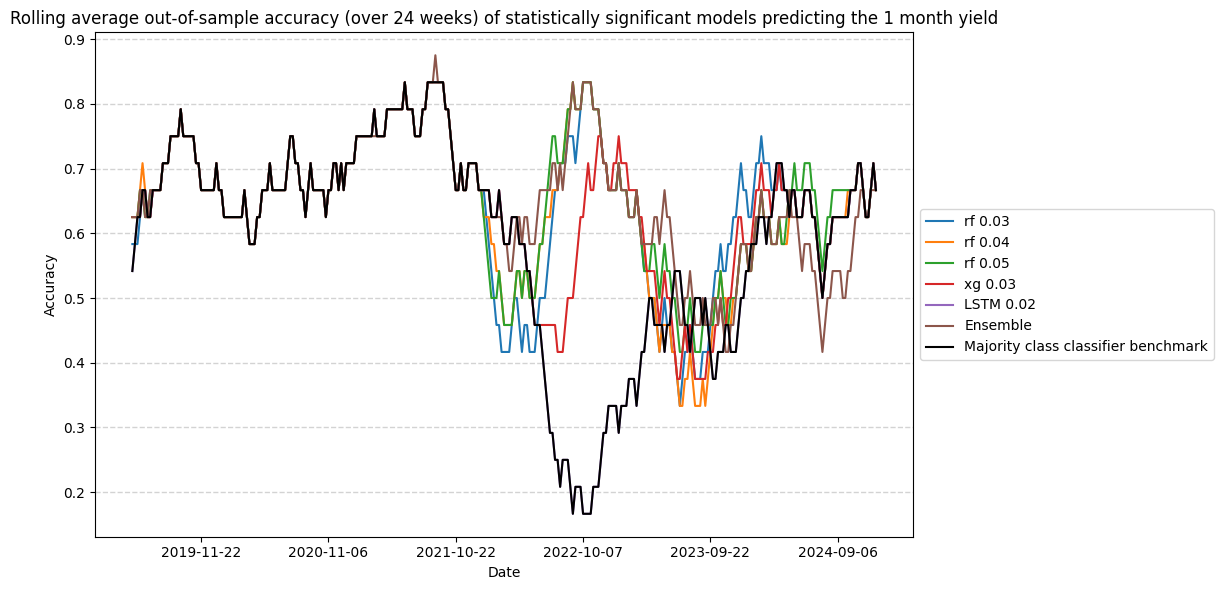

In [81]:
col = 'Y_DGS1MO'

forecast = {
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0)[col],
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0)[col],
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0)[col],
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0)[col],
             }
forecast = pd.DataFrame(forecast)

forecast_lstm = pd.read_csv("results of models/forecast_LSTM_cls_12864128_0.02MI_2patience_52LB_evalsscores.csv",index_col=0)[col]
forecast_lstm = (forecast_lstm>0.5).astype(int)
forecast_lstm.name = 'LSTM 0.02'

ensemble = ensemble_short[col]
ensemble.name = 'Ensemble'

bench = majority_class_classifier[col]
bench.name = "Majority class classifier benchmark"

forecast= pd.concat([forecast,forecast_lstm,ensemble,bench],axis =1).round(2)
forecast.index = Yw.iloc[780:Yw.shape[0]-1].index 


true_values = Yw.iloc[780:Yw.shape[0]-1][col]
fig, ax = plt.subplots(figsize=(12, 6))

for model in forecast.columns:
    correct = (forecast[model] == true_values)
    rolling_acc = correct.rolling(window=24).mean()

    if model == "Majority class classifier benchmark":
        rolling_acc.plot(ax=ax, label=model,color = 'black')
    
    else:
        rolling_acc.plot(ax=ax, label=model)

    

ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=1)
plt.title(f"Rolling average out-of-sample accuracy (over 24 weeks) of statistically significant models predicting the 1 month yield")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


We can see from the plot above that the majority class classifier benchmark (black line) is difficult to beat consistently through time:
- on the period 2018-2021, the benchmark provides almost systematically an rolling accuracy that is as good as that of the other models learning the 1 month yield. This suggest that models are not learning much things from our features on this period. 
- after 2021, the models start beating the benchmark. This is probably the effect of the rates hikes after the covid pandemic. The models have probably learned something from the macro and monetary variables included in the dataset at that time. 
- We can see that our models have a rolling average out-of-sample accuracy that is most of the time above 0.5, but this rolling average is quite volatile, which shows that there are periods in which the models perform very poorly. 

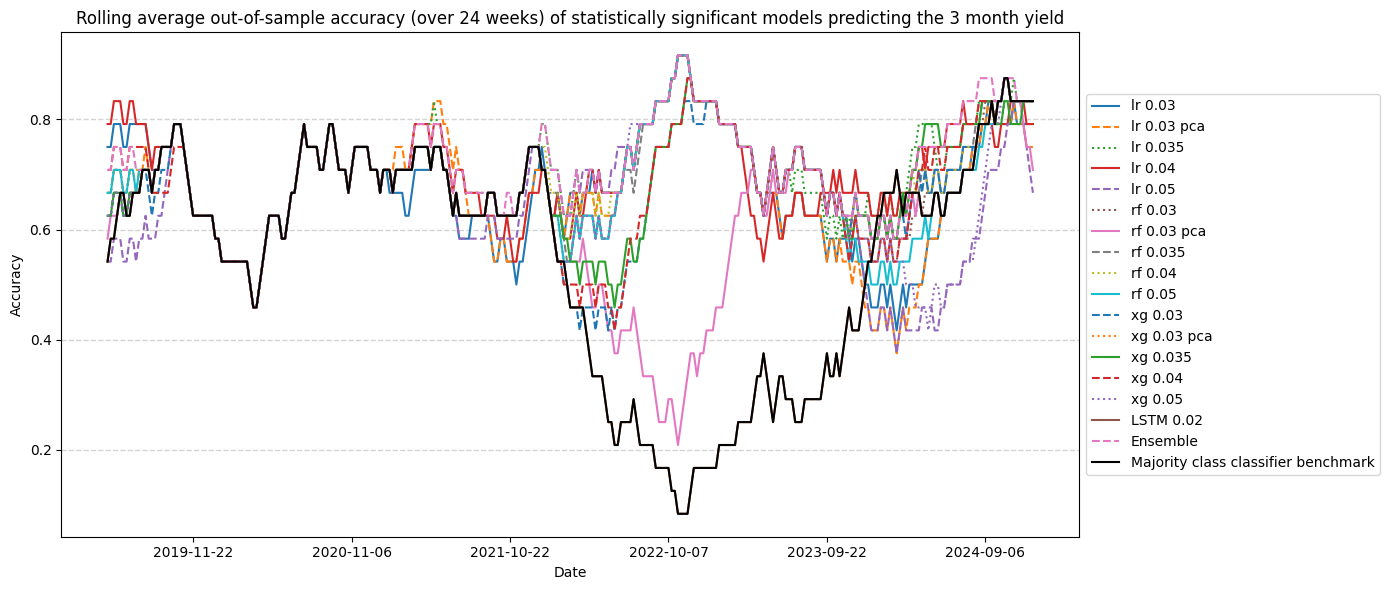

In [ ]:
col = 'Y_DGS3MO'

forecast = {
            "lr 0.03":pd.read_csv("results of models/forecast logistic regression, 15y train test.csv",index_col=0)[col],
            "lr 0.03 pca":pd.read_csv("results of models/forecast logistic regression pca, 15y train test.csv", index_col=0)[col],
            "lr 0.035":pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0)[col],
            "lr 0.04":pd.read_csv("results of models/forecast logistic regression, MI 0.04, 15y train test.csv", index_col=0)[col],
            "lr 0.05":pd.read_csv("results of models/forecast logistic regression, MI 0.05, 15y train test.csv", index_col=0)[col],
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0)[col],
            "rf 0.03 pca":pd.read_csv("results of models/forecast random forest pca, 15y train test.csv", index_col=0)[col],
            "rf 0.035":pd.read_csv("results of models/forecast random forest, MI 0.035, 15y train test.csv", index_col=0)[col],
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0)[col],
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0)[col],
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0)[col],
             "xg 0.03 pca":pd.read_csv("results of models/forecast xgboost, pca, 15y train test.csv", index_col=0)[col],
            "xg 0.035":pd.read_csv("results of models/forecast xgboost, MI 0.035, 15y train test.csv",index_col=0)[col],
            "xg 0.04":pd.read_csv("results of models/forecast xgboost, MI 0.04, 15y train test.csv", index_col=0)[col],
            "xg 0.05":pd.read_csv("results of models/forecast xgboost, MI 0.05, 15y train test.csv", index_col=0)[col]
             }
forecast = pd.DataFrame(forecast)

forecast_lstm = pd.read_csv("results of models/forecast_LSTM_cls_12864128_0.02MI_2patience_52LB_evalsscores.csv",index_col=0)[col]
forecast_lstm = (forecast_lstm>0.5).astype(int)
forecast_lstm.name = 'LSTM 0.02'

ensemble = ensemble_short[col]
ensemble.name = 'Ensemble'
bench = majority_class_classifier[col]
bench.name = "Majority class classifier benchmark"

forecast= pd.concat([forecast,forecast_lstm,ensemble,bench],axis =1).round(2)
forecast.index = Yw.iloc[780:Yw.shape[0]-1].index 


true_values = Yw.iloc[780:Yw.shape[0]-1][col]
fig, ax = plt.subplots(figsize=(14, 6))

style_cycle = cycle(["-", "--", ":"])

for model in forecast.columns:
    correct = (forecast[model] == true_values)
    rolling_acc = correct.rolling(window=24).mean()

    if model == "Majority class classifier benchmark":
        rolling_acc.plot(ax=ax, label=model,color = 'black')
    
    else:
        rolling_acc.plot(ax=ax, label=model,linestyle = next(style_cycle))

    

ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=1)
plt.title(f"Rolling average out-of-sample accuracy (over 24 weeks) of statistically significant models predicting the 3 month yield")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


The results are more satisfactory for the 3-month yields, but the overall pattern remains similar to that of the models for the 1-month yields: a significant number of models manage to outperform the benchmark starting from late 2021. Before that, the benchmark delivers performance that is generally quite similar to the models. We also observe some volatility in the models’ accuracy. The logistic regression models appear to be slightly more stable than the others, as does the ensemble model.


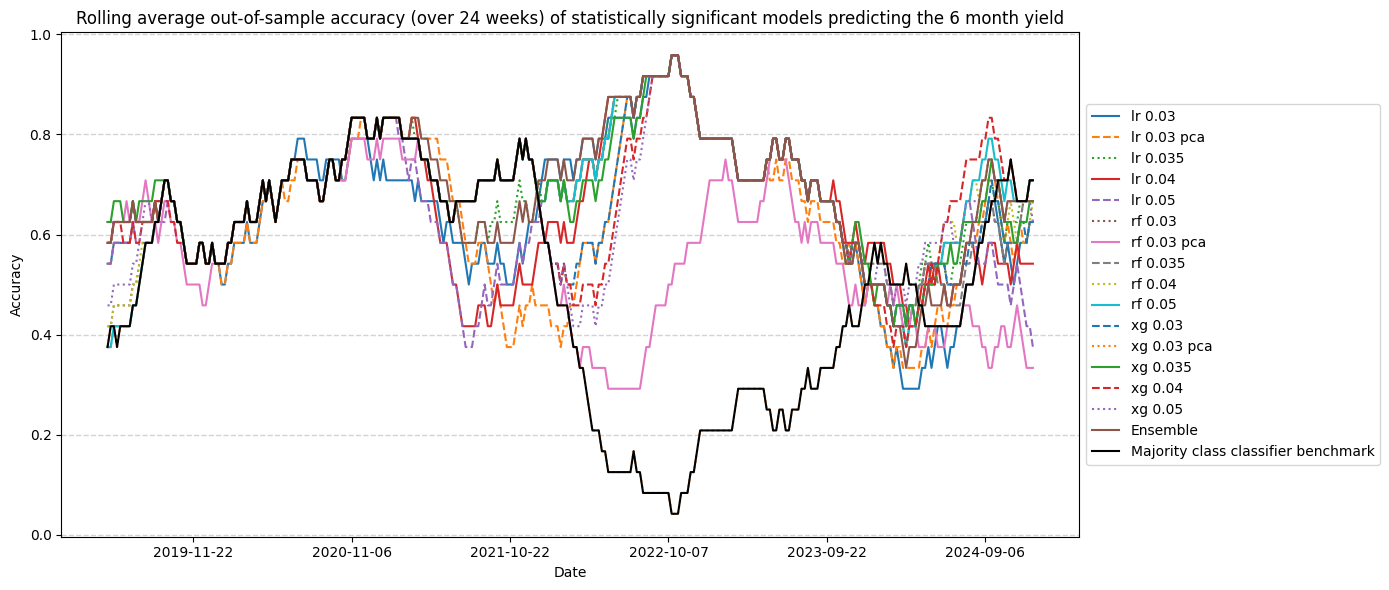

In [83]:
col = 'Y_DGS6MO'
forecast = {
            "lr 0.03":pd.read_csv("results of models/forecast logistic regression, 15y train test.csv",index_col=0)[col],
            "lr 0.03 pca":pd.read_csv("results of models/forecast logistic regression pca, 15y train test.csv", index_col=0)[col],
            "lr 0.035":pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0)[col],
            "lr 0.04":pd.read_csv("results of models/forecast logistic regression, MI 0.04, 15y train test.csv", index_col=0)[col],
            "lr 0.05":pd.read_csv("results of models/forecast logistic regression, MI 0.05, 15y train test.csv", index_col=0)[col],
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0)[col],
            "rf 0.03 pca":pd.read_csv("results of models/forecast random forest pca, 15y train test.csv", index_col=0)[col],
            "rf 0.035":pd.read_csv("results of models/forecast random forest, MI 0.035, 15y train test.csv", index_col=0)[col],
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0)[col],
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0)[col],
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0)[col],
             "xg 0.03 pca":pd.read_csv("results of models/forecast xgboost, pca, 15y train test.csv", index_col=0)[col],
            "xg 0.035":pd.read_csv("results of models/forecast xgboost, MI 0.035, 15y train test.csv",index_col=0)[col],
            "xg 0.04":pd.read_csv("results of models/forecast xgboost, MI 0.04, 15y train test.csv", index_col=0)[col],
            "xg 0.05":pd.read_csv("results of models/forecast xgboost, MI 0.05, 15y train test.csv", index_col=0)[col]
             }
forecast = pd.DataFrame(forecast)


ensemble = ensemble_short[col]
ensemble.name = 'Ensemble'
bench = majority_class_classifier[col]
bench.name = "Majority class classifier benchmark"

forecast= pd.concat([forecast,ensemble,bench],axis =1).round(2)
forecast.index = Yw.iloc[780:Yw.shape[0]-1].index 


true_values = Yw.iloc[780:Yw.shape[0]-1][col]
fig, ax = plt.subplots(figsize=(14, 6))

style_cycle = cycle(["-", "--", ":"])

for model in forecast.columns:
    correct = (forecast[model] == true_values)
    rolling_acc = correct.rolling(window=24).mean()

    if model == "Majority class classifier benchmark":
        rolling_acc.plot(ax=ax, label=model,color = 'black')
    
    else:
        rolling_acc.plot(ax=ax, label=model,linestyle = next(style_cycle))

    

ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=1)
plt.title(f"Rolling average out-of-sample accuracy (over 24 weeks) of statistically significant models predicting the 6 month yield")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


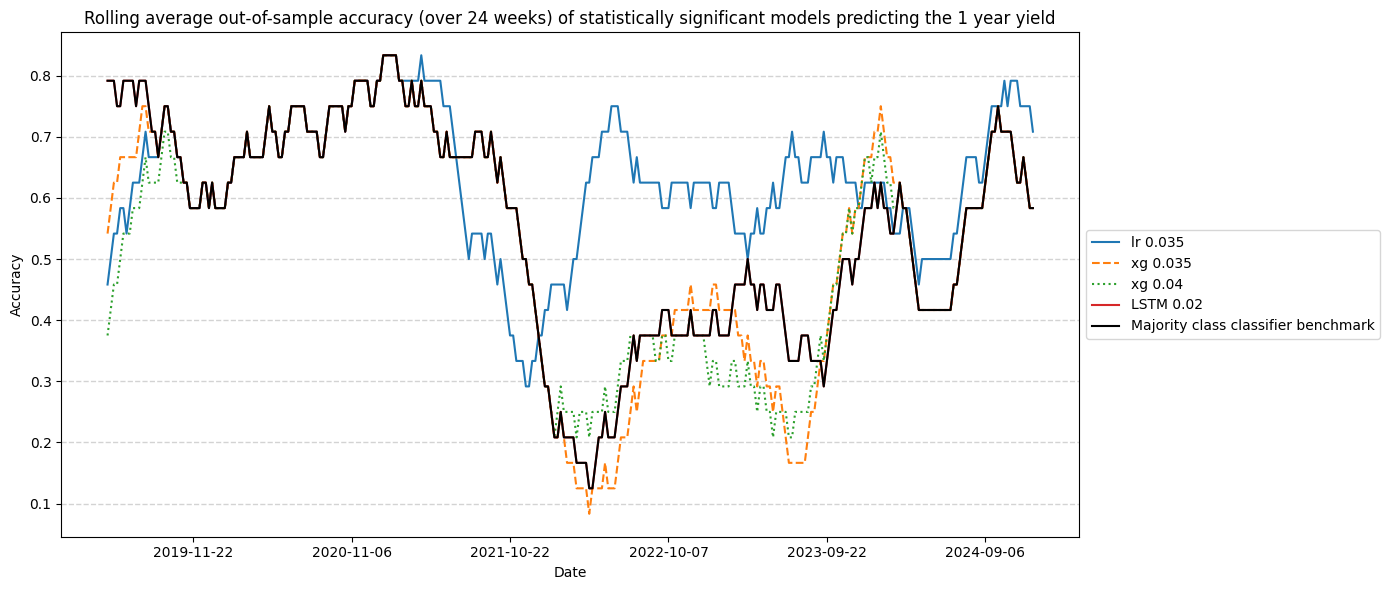

In [ ]:
col = 'Y_DGS1'

forecast = {
            "lr 0.035":pd.read_csv("results of models/forecast logistic regression, MI 0.035, 15y train test.csv", index_col=0)[col],
            "xg 0.035":pd.read_csv("results of models/forecast xgboost, MI 0.035, 15y train test.csv",index_col=0)[col],
            "xg 0.04":pd.read_csv("results of models/forecast xgboost, MI 0.04, 15y train test.csv", index_col=0)[col],
             }
forecast = pd.DataFrame(forecast)

forecast_lstm = pd.read_csv("results of models/forecast_LSTM_cls_12864128_0.02MI_2patience_52LB_evalsscores.csv",index_col=0)[col]
forecast_lstm = (forecast_lstm>0.5).astype(int)
forecast_lstm.name = 'LSTM 0.02'

bench = majority_class_classifier[col]
bench.name = "Majority class classifier benchmark"

forecast= pd.concat([forecast,forecast_lstm,bench],axis =1).round(2)
forecast.index = Yw.iloc[780:Yw.shape[0]-1].index 


true_values = Yw.iloc[780:Yw.shape[0]-1][col]
fig, ax = plt.subplots(figsize=(14, 6))

style_cycle = cycle(["-", "--", ":"])

for model in forecast.columns:
    correct = (forecast[model] == true_values)
    rolling_acc = correct.rolling(window=24).mean()

    if model == "Majority class classifier benchmark":
        rolling_acc.plot(ax=ax, label=model,color = 'black')
    
    else:
        rolling_acc.plot(ax=ax, label=model,linestyle = next(style_cycle))

    

ax.grid(axis='y', color='lightgrey', linestyle='--', linewidth=1)
plt.title(f"Rolling average out-of-sample accuracy (over 24 weeks) of statistically significant models predicting the 1 year yield")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Once again the benchmark is difficult to beat consistently. 

## E) Feature importance analysis

In [ ]:
col = 'Y_DGS1MO'

forecast = {
            "rf 0.03":pd.read_csv("results of models/forecast random forest, no pca, 15y train test.csv", index_col=0)[col],
             "rf 0.04":pd.read_csv("results of models/forecast random forest, MI 0.04, 15y train test.csv", index_col=0)[col],
             "rf 0.05":pd.read_csv("results of models/forecast random forest, MI 0.05, 15y train test.csv", index_col=0)[col],
             "xg 0.03":pd.read_csv("results of models/forecast xgboost, 15y train test.csv", index_col=0)[col],
             }
forecast = pd.DataFrame(forecast)
